# Исследование для интернет-магазина «В один клик»

Интернет-магазин «В один клик» специализируется на продаже разных товаров. Отчет магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход - удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений. Руководство интернет-магазина «В один клик» хочет принимать решения только на основе анализа данных и бизнес-моделирования.

**Цель исследования:** разработка решения, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

**Ход исследования**

Данные для исследования будут получены из четырех файлов. О качестве данных ничего не известно, поэтому перед тем, как приступать к целям исследования, понадобится обзор данных.

1. Маркировка уровня финансовой активности постоянных покупателей:
* «снизилась», если клиент стал покупать меньше товаров
* «прежний уровень», если ничего не изменилось

2. Сбор данных по клиентам по следующим группам:
* признаки, которые описывают коммуникацию сотрудников компании с клиентом
* признаки, которые описывают продуктовое поведение покупателя (например, какие товары покупает и как часто)
* признаки, которые описывают покупательское поведение клиента (например, сколько тратил в магазине)
* признаки, которые описывают поведение покупателя на сайте (например, как много страниц просматривает и сколько времени проводит на сайте)

3. Построение модели, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
4. Включение в исследование дополнительных данных финансового департамента о прибыльности клиента (какой доход каждый покупатель приносил компании за последние три месяца).
5. Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

**Этапы исследования:**

1. Загрузка и обзор данных
2. Предобработка данных
3. Исследовательский анализ
4. Объединение таблиц
5. Корреляционный анализ
6. Использование пайплайнов
7. Анализ важности признаков
8. Написание общего вывода

## Загрузка данных

Установим и импортируем необходимые для исследования библиотеки:

In [1]:
!pip install phik -q
!pip install shap -q
#!pip install scikit-learn==1.6 -q

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import phik
from phik.report import plot_correlation_matrix
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    PolynomialFeatures
)
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.svm import SVC
import shap
from sklearn.inspection import permutation_importance

Откроем файлы с датасетом:

In [3]:
try:
    market_file = pd.read_csv('/datasets/market_file.csv', sep=',', decimal='.')
except:
    market_file = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv', sep=',', decimal='.')

In [4]:
try:
    market_money = pd.read_csv('/datasets/market_money.csv', sep=',', decimal='.')
except:
    market_money = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv', sep=',', decimal='.')

In [5]:
try:
    market_time = pd.read_csv('/datasets/market_time.csv', sep=',', decimal='.')
except:
    market_time = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv', sep=',', decimal='.')

In [6]:
try:
    money = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')
except:
    money = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv', sep=';', decimal=',')

In [7]:
dataframes = {
    'market_file': market_file,
    'market_money': market_money,
    'market_time': market_time,
    'money': money
}

Выведем первые строки и общую информацию о датасете `market_file`:

In [8]:
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


Таблица содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении:
* `id` - номер покупателя в корпоративной базе данных
* `Покупательская активность` - рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень»
* `Тип сервиса` - уровень сервиса (например «премиум» и «стандарт»)
* `Разрешить сообщать` - информация о том, можно ли присылать покупателю дополнительные предложения о товаре (согласие на это дает покупатель)
* `Маркет_актив_6_мес` - среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев (т.е. какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента)
* `Маркет_актив_тек_мес` - количество маркетинговых коммуникаций в текущем месяце
* `Длительность` - значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте
* `Акционные_покупки` - среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев
* `Популярная_категория` - самая популярная категория товаров у покупателя за последние 6 месяцев
* `Средний_просмотр_категорий_за_визит` - показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца
* `Неоплаченные_продукты_штук_квартал` - общее число неоплаченных товаров в корзине за последние 3 месяца
* `Ошибка_сервиса` - число сбоев, которые коснулись покупателя во время посещения сайта
* `Страниц_за_визит` - среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца

In [9]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

Выведем первые строки и общую информацию о датасете `market_money`:

In [10]:
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


Таблица содержит данные о выручке, которую получает магазин с покупателя, т.е. сколько покупатель всего потратил за период взаимодействия с сайтом:
* `id` - номер покупателя в корпоративной базе данных
* `Период` - название периода, во время которого зафиксирована выручка (например, 'текущий_месяц' или 'предыдущий_месяц')
* `Выручка` - сумма выручки за период

In [11]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


Выведем первые строки и общую информацию о датасете `market_time`:

In [12]:
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


Таблица с данными о времени (в минутах), которое покупатель провел на сайте в течение периода:
* `id` - номер покупателя в корпоративной базе данных
* `Период` - название периода, во время которого зафиксировано общее время
* `минут` - значение времени, проведенного на сайте, в минутах

In [13]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


Выведем первые строки и общую информацию о датасете `money`:

In [14]:
money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


Таблица содержит данные о среднемесячной прибыли покупателя за последние 3 месяца (какую прибыль получает магазин от продаж каждому покупателю):
* `id` - номер покупателя в корпоративной базе данных
* `Прибыль` - значение прибыли

In [15]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Данные в таблицах соответствуют описанию задач, поэтому можно приступать к предобработке данных.

## Предобработка данных

Заменим названия столбцов во всех датафреймах - приведем их к нижнему регистру:

In [16]:
for name, df in dataframes.items():
    df.columns = [re.sub(r'(?<!^)(?=[A-ZА-Я])', '', i).replace(' ', '_').lower() for i in df.columns]

Проверим названия столбцов у всех датафреймов:

In [17]:
for name, df in dataframes.items():
    print(f'{name}: {"; ".join(df.columns.tolist())}\n')

market_file: id; покупательская_активность; тип_сервиса; разрешить_сообщать; маркет_актив_6_мес; маркет_актив_тек_мес; длительность; акционные_покупки; популярная_категория; средний_просмотр_категорий_за_визит; неоплаченные_продукты_штук_квартал; ошибка_сервиса; страниц_за_визит

market_money: id; период; выручка

market_time: id; период; минут

money: id; прибыль



Названия столбцов приведены к нижнему регистру и оставлены кириллическими.

Проверим датафреймы на наличие пропусков в данных:

In [18]:
for name, df in dataframes.items():
    print(f'{name}:')
    print(f'{df.isna().sum()}\n')

market_file:
id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
dtype: int64

market_money:
id         0
период     0
выручка    0
dtype: int64

market_time:
id        0
период    0
минут     0
dtype: int64

money:
id         0
прибыль    0
dtype: int64



Пропущенных данных не обнаружено. Далее проверим датафреймы на наличие явных дубликатов:

In [19]:
for name, df in dataframes.items():
    print(f'{name} - {df.duplicated().sum()}')

market_file - 0
market_money - 0
market_time - 0
money - 0


В датафреймах не обнаружены явные дубликаты. Произведем проверку на наличие неявных дубликатов. Проверим текстовые столбцы датафрейма `market_file` на наличие неявных дубликатов:

In [20]:
for name, df in dataframes.items():
    print(f'-------------------------------\n{name}:')
    for i in df.columns:
        if df[i].dtype == 'object':
            print(f'{i}: {"; ".join(df[i].unique().tolist())}')

-------------------------------
market_file:
покупательская_активность: Снизилась; Прежний уровень
тип_сервиса: премиум; стандартт; стандарт
разрешить_сообщать: да; нет
популярная_категория: Товары для детей; Домашний текстиль; Косметика и аксесуары; Техника для красоты и здоровья; Кухонная посуда; Мелкая бытовая техника и электроника
-------------------------------
market_money:
период: препредыдущий_месяц; текущий_месяц; предыдущий_месяц
-------------------------------
market_time:
период: текущий_месяц; предыдцщий_месяц
-------------------------------
money:


В датафрейме `market_file` в столбце `тип_сервиса` обнаружен неявный дубликат - `стандарт <=> стандартт`. Устраним данный неявный дубликат:

In [21]:
market_file['тип_сервиса'] = market_file['тип_сервиса'].replace('стандартт', 'стандарт')
market_file['тип_сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

В датафрейме `market_money` в столбце `период` обнаружено странное значение - `препредыдущий_месяц`. Попробуем разобраться, неявный ли это дубликат значения `предыдущий_месяц`:

In [22]:
market_money['период'].value_counts()

препредыдущий_месяц    1300
текущий_месяц          1300
предыдущий_месяц       1300
Name: период, dtype: int64

In [23]:
(market_money.pivot_table(index='id', values='период', aggfunc='count').reset_index())['период'].value_counts()

3    1300
Name: период, dtype: int64

Получилось, что в датафрейме `market_money` каждый `id` повторяется 3 раза, т.е. для него данные представлены за три месяца - текущий, предыдущий и препредыдущий месяц. Таким образом, неявных дубликатов нет. Приведем данные к стандартному виду, заменив нижнее подчеркивание на пробел:

In [24]:
market_money['период'] = market_money['период'].str.replace('_', ' ')
market_money['период'].unique()

array(['препредыдущий месяц', 'текущий месяц', 'предыдущий месяц'],
      dtype=object)

In [25]:
market_money['период'].value_counts()

текущий месяц          1300
препредыдущий месяц    1300
предыдущий месяц       1300
Name: период, dtype: int64

В датафрейме `market_time` в столбце `период` исправим ошибку в наименовании значения (`предыдцщий_месяц`) и приведем данные к стандартному виду, заменив нижнее подчеркивание на пробел:

In [26]:
market_time['период'] = market_time['период'].replace('предыдцщий_месяц', 'предыдущий месяц').str.replace('_', ' ')
market_time['период'].unique()

array(['текущий месяц', 'предыдущий месяц'], dtype=object)

В рамках предобработки данных были сделаны проверки на пропуски и дубликаты, удалены неявные дубликаты, в п.1 исследования общая информация по каждому датафрейму показала, что типы данных в столбцах соответствуют формату данных. Таким образом, датафреймы подготовлены для проведения исследовательского анализа данных.

## Исследовательский анализ данных

Для отображения количественных признаков из датафреймов в виде гистограмм и диаграмм размаха ("ящик с усами") создадим функцию:

In [27]:
def show_graph_1(df_col, hist_title, boxplot_title):
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1).grid(True)
    plt.hist(df_col, bins=30)
    plt.title(hist_title)
    plt.subplot(1, 2, 2).grid(True)
    plt.boxplot(df_col)
    plt.title(boxplot_title)
    plt.show()

Для отображения качественных признаков из датафреймов в виде столбчатых и круговых диаграмм создадим функцию:

In [28]:
def show_graph_2(df_col, bar_title, bar_xlabel, pie_title):
    counts = df_col.value_counts(ascending=True)
    plt.figure(figsize=(13, 5))
    plt.subplot(1, 2, 1)
    counts.plot(kind='bar', title=bar_title, grid=True, xlabel=bar_xlabel, ylabel='Количество')
    plt.subplot(1, 2, 2)
    counts.plot(kind='pie', ylabel='', title=pie_title, autopct='%1.1f%%')
    plt.show()

Для вывода количественных и качественных признаков датафрейма определим функцию:

In [29]:
# категориальные и количественные признаки
def get_columns(df):
    return {
        'cat_col_names': df.select_dtypes(exclude='number').columns.tolist(),
        'num_col_names': df.select_dtypes(include='number').columns.tolist()
    }

### Датафрейм `market_file`

#### Количественные признаки

Определим количественные признаки датафрейма `market_file`:

In [30]:
get_columns(market_file)['num_col_names']

['id',
 'маркет_актив_6_мес',
 'маркет_актив_тек_мес',
 'длительность',
 'акционные_покупки',
 'средний_просмотр_категорий_за_визит',
 'неоплаченные_продукты_штук_квартал',
 'ошибка_сервиса',
 'страниц_за_визит']

Проведем исследовательский анализ количественных данных датафрейма `market_file`. Выведем характеристики, дающие представление о выборке (числовое описание данных):

In [31]:
market_file.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1300.0,215997.500000,375.421985,215348.0,215672.75,215997.50,216322.25,216647.00
маркет_актив_6_мес,1300.0,4.253769,1.014814,0.9,3.70,4.20,4.90,6.60
маркет_актив_тек_мес,1300.0,4.011538,0.696868,3.0,4.00,4.00,4.00,5.00
длительность,1300.0,601.898462,249.856289,110.0,405.50,606.00,806.00,1079.00
акционные_покупки,1300.0,0.319808,0.249843,0.0,0.17,0.24,0.30,0.99
средний_просмотр_категорий_за_визит,1300.0,3.270000,1.355350,1.0,2.00,3.00,4.00,6.00
неоплаченные_продукты_штук_квартал,1300.0,2.840000,1.971451,0.0,1.00,3.00,4.00,10.00
ошибка_сервиса,1300.0,4.185385,1.955298,0.0,3.00,4.00,6.00,9.00
страниц_за_визит,1300.0,8.176923,3.978126,1.0,5.00,8.00,11.00,20.00


Отобразим гистограмму и "ящик с усами" для столбца `маркет_актив_6_мес`:

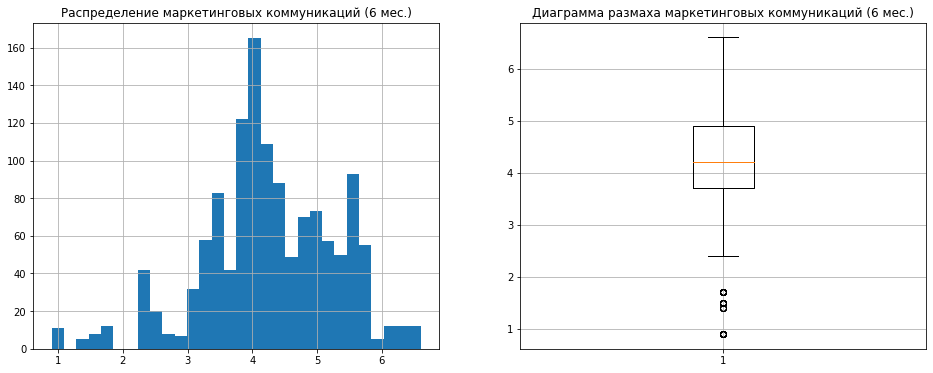

In [32]:
show_graph_1(market_file['маркет_актив_6_мес'], 'Распределение маркетинговых коммуникаций (6 мес.)', 'Диаграмма размаха маркетинговых коммуникаций (6 мес.)')

Распределение признака приближено к нормальному - среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев (число рассылок, звонков, показов рекламы и пр.) в большинстве случаев составляет 4 коммуникации в месяц. Выбросы, значение которых меньше 2, оставляем в выборке, т.к. они не являются аномальными значениями.

Отобразим гистограмму и "ящик с усами" для столбца `маркет_актив_тек_мес`:

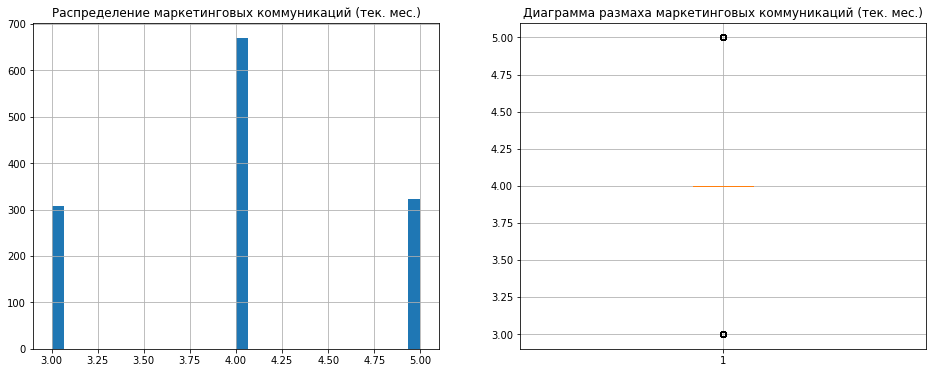

In [33]:
show_graph_1(market_file['маркет_актив_тек_мес'], 'Распределение маркетинговых коммуникаций (тек. мес.)', 'Диаграмма размаха маркетинговых коммуникаций (тек. мес.)')

На гистограмме данные сгруппированы в три столбца, т.к. этот признак представлен тремя значениями (3, 4 и 5). Количество маркетинговых коммуникаций в текущем месяце выросло, по сравнению с последним полугодием. Распределение имеет подобие нормального, аномалий для исключения из выборки нет.

Отобразим гистограмму и "ящик с усами" для столбца `длительность`:

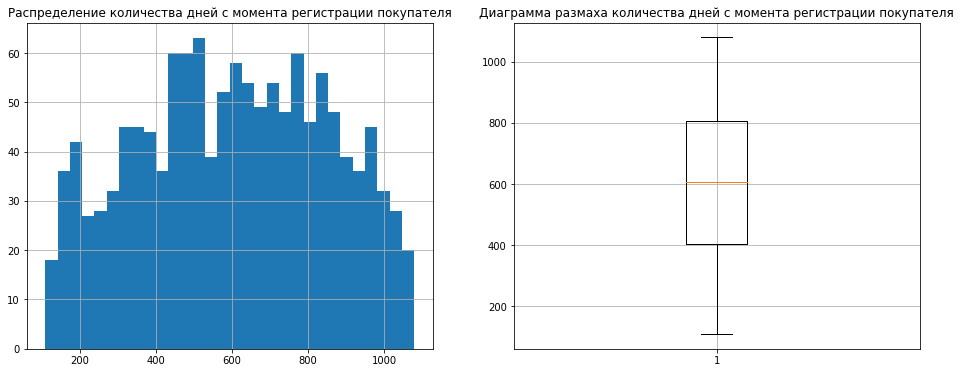

In [34]:
show_graph_1(market_file['длительность'], 'Распределение количества дней с момента регистрации покупателя', 'Диаграмма размаха количества дней с момента регистрации покупателя')

Можно сказать, что данные равномерно распределены, что говорит о том, что на сайте каждый день регистрируется примерно одинаковое количество людей. Диаграмма размаха показывает, что все значения находятся в пределах нормы.

Отобразим гистограмму и "ящик с усами" для столбца `акционные_покупки`:

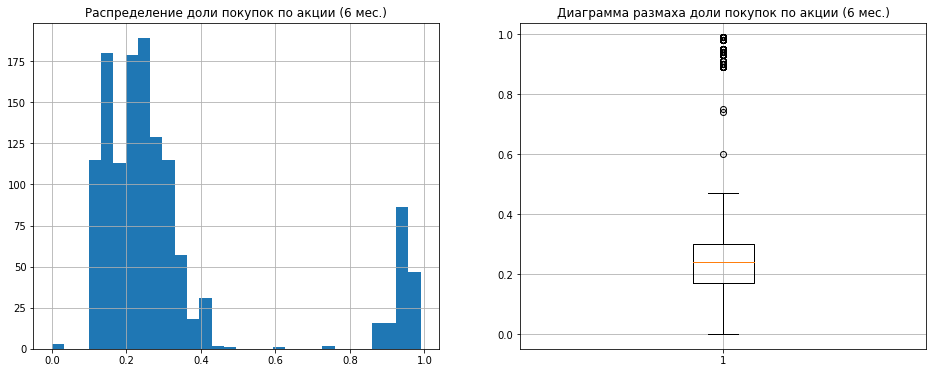

In [35]:
show_graph_1(market_file['акционные_покупки'], 'Распределение доли покупок по акции (6 мес.)', 'Диаграмма размаха доли покупок по акции (6 мес.)')

По гистограмме можно сказать, что в выборке есть клиенты, которые покупают товары только по акции. Данные по среднемесячной доле покупок по акции от общего числа покупок за последние 6 месяцев имеют распределение с двумя пиками, возможно, их можно разделить на две части с границей 0.7. Выбросы из датасета также не стоит удалять.

Отобразим гистограмму и "ящик с усами" для столбца `средний_просмотр_категорий_за_визит`:

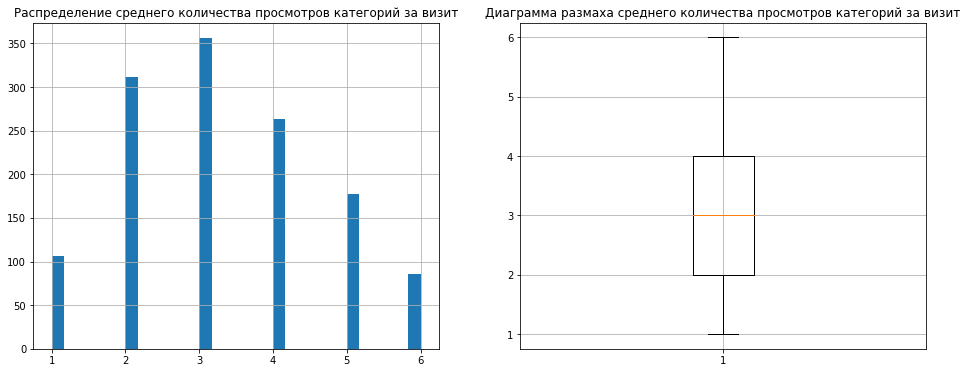

In [36]:
show_graph_1(market_file['средний_просмотр_категорий_за_визит'], 'Распределение среднего количества просмотров категорий за визит', 'Диаграмма размаха среднего количества просмотров категорий за визит')

На гистограмме данные сгруппированы в шесть столбцов, т.к. этот признак представлен шестью значениями (от 1 до 6). В большинстве случае за визит в течение последнего месяца в среднем покупатель просматривает три категории, среди пользователей нет тех, кто не смотрел хоть что-то за последний месяц. Распределение похоже на нормальное, все значения находятся в пределах нормы.

Отобразим гистограмму и "ящик с усами" для столбца `неоплаченные_продукты_штук_квартал`:

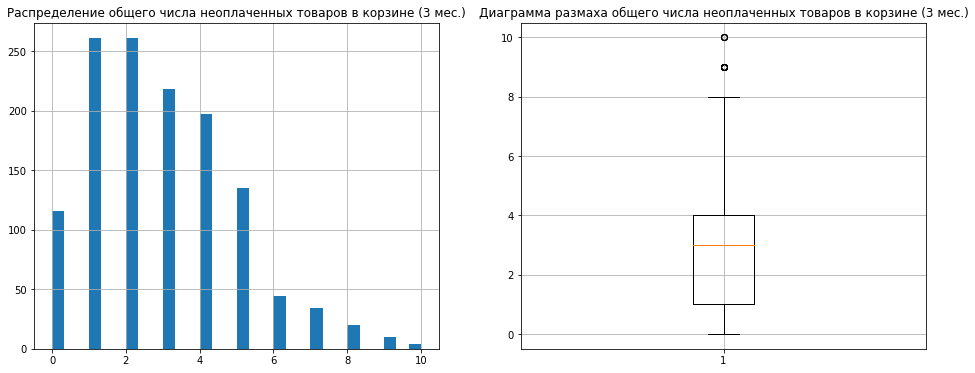

In [37]:
show_graph_1(market_file['неоплаченные_продукты_штук_квартал'], 'Распределение общего числа неоплаченных товаров в корзине (3 мес.)', 'Диаграмма размаха общего числа неоплаченных товаров в корзине (3 мес.)')

Распределение общего числа неоплаченных товаров в корзине за последние 3 месяца похоже на смещенное нормальное распределение или распределение Пуассона. Распределение показывает, что за квартал наиболее вероятное количество неоплаченных товаров 1-2. Добавим в датафрейм новый категориальный признак на основе количественного:

In [38]:
market_file['неоплаченные_продукты_штук_квартал_кат'] = market_file['неоплаченные_продукты_штук_квартал'].apply(lambda x: 'низкий' if x <= 5 else 'высокий')

Отобразим гистограмму и "ящик с усами" для столбца `ошибка_сервиса`:

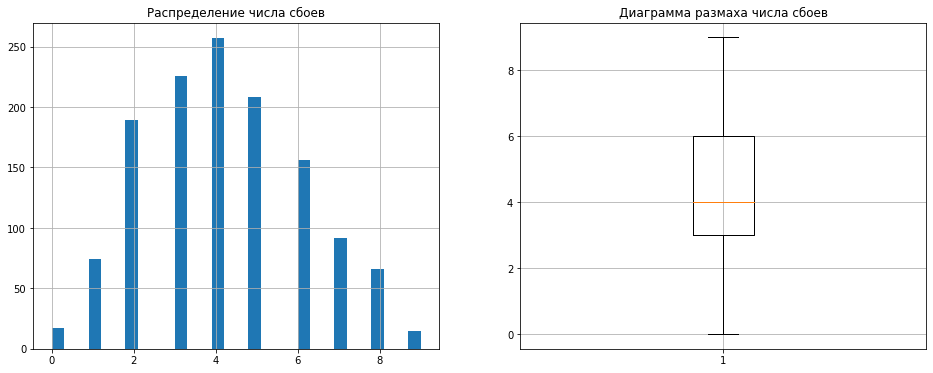

In [39]:
show_graph_1(market_file['ошибка_сервиса'], 'Распределение числа сбоев', 'Диаграмма размаха числа сбоев')

Распределение числа сбоев, с которыми столкнулись покупатели во время посещения сайта, похоже на нормальное. Выбросов в данных не наблюдается. 

Отобразим гистограмму и "ящик с усами" для столбца `страниц_за_визит`:

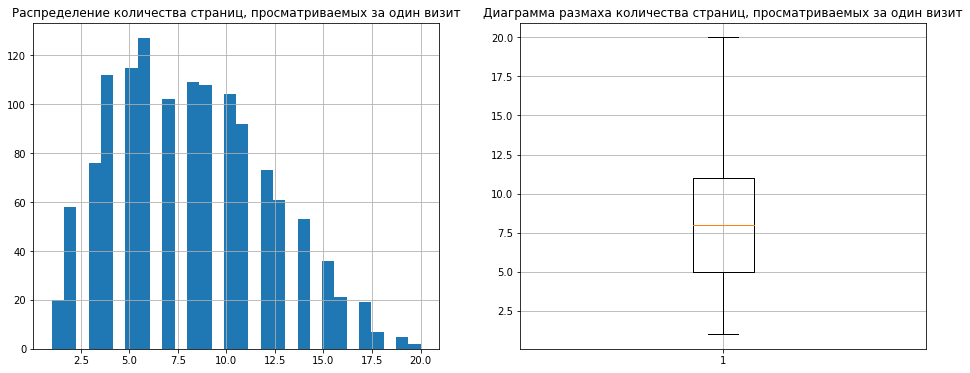

In [40]:
show_graph_1(market_file['страниц_за_визит'], 'Распределение количества страниц, просматриваемых за один визит', 'Диаграмма размаха количества страниц, просматриваемых за один визит')

Распределение среднего количества страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца, похоже на нормальное со сдвигом, или распределение Пуассона. Наиболее вероятное значение среднего числа просмотренных страниц лежит в районе 5-6. Все значения находятся в пределах нормы.

#### Категориальные признаки

Определим категориальные признаки датафрейма `market_file`:

In [41]:
get_columns(market_file)['cat_col_names']

['покупательская_активность',
 'тип_сервиса',
 'разрешить_сообщать',
 'популярная_категория',
 'неоплаченные_продукты_штук_квартал_кат']

Проведем исследовательский анализ категориальных данных датафрейма `market_file`.

Отобразим столбчатую и круговую диаграммы для столбца `покупательская_активность`:

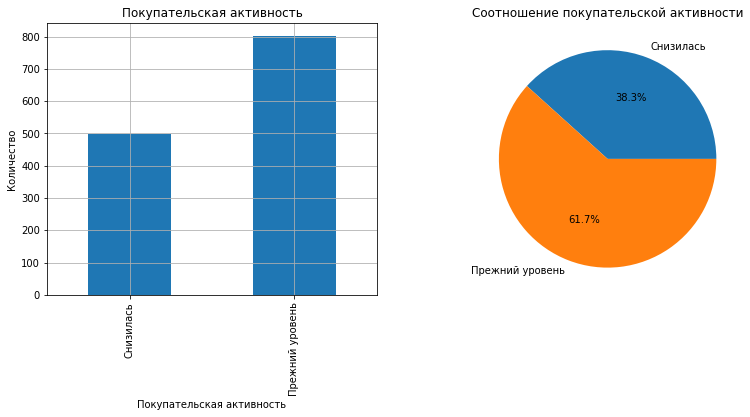

In [42]:
show_graph_2(market_file['покупательская_активность'], 'Покупательская активность', 'Покупательская активность', 'Соотношение покупательской активности')

В 62% случаев покупательская активность осталась на прежнем уровне, а в 32% - снизилась.

Отобразим столбчатую и круговую диаграммы для столбца `тип_сервиса`:

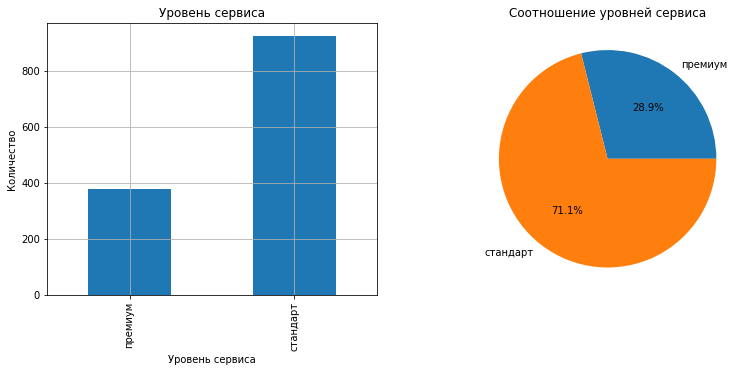

In [43]:
show_graph_2(market_file['тип_сервиса'], 'Уровень сервиса', 'Уровень сервиса', 'Соотношение уровней сервиса')

Большую долю уровня сервиса занимает "Стандарт" (71%), уровень сервиса "Премиум" составляет меньшую долю (29%).

Отобразим столбчатую и круговую диаграммы для столбца `разрешить_сообщать`:

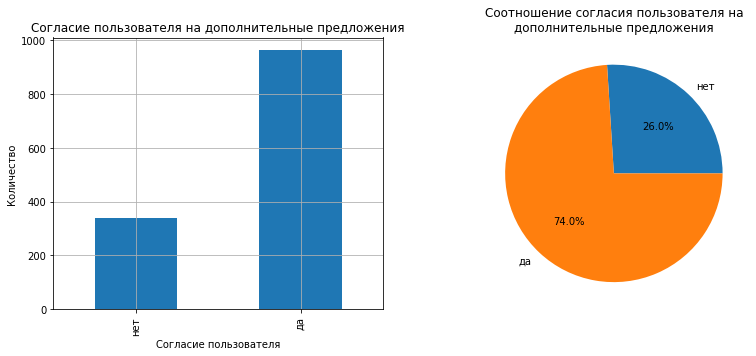

In [44]:
show_graph_2(market_file['разрешить_сообщать'], 'Согласие пользователя на дополнительные предложения', 'Согласие пользователя', 'Соотношение согласия пользователя на\nдополнительные предложения')

74% пользователей дали согласие на рассылку информации о дополнительных предложениях о товаре.

Отобразим столбчатую и круговую диаграммы для столбца `популярная_категория`:

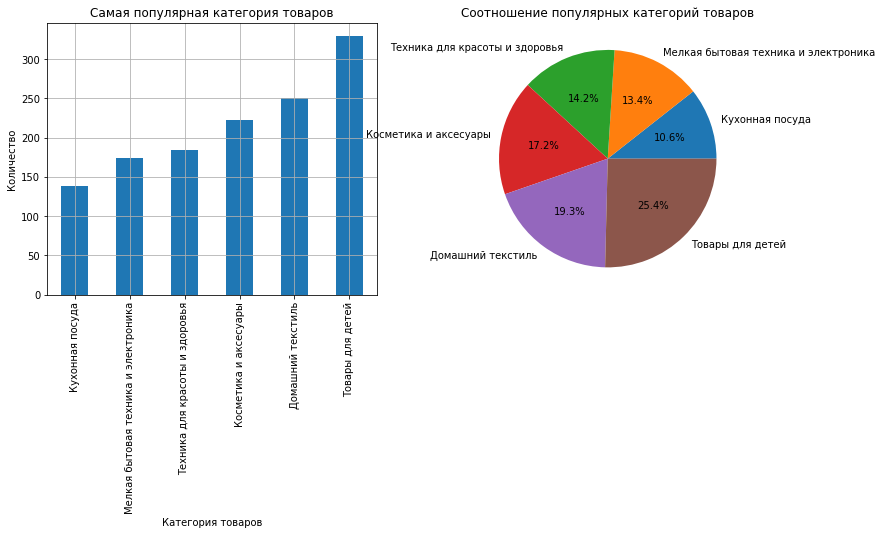

In [45]:
show_graph_2(market_file['популярная_категория'], 'Cамая популярная категория товаров', 'Категория товаров', 'Соотношение популярных категорий товаров')

За последние полгода самая популярная категория товаров у покупателей - "Товары для детей" (25%). Категория "Кухонная посуда" является наименее популярной категорией (11%).

### Датафрейм `market_money`

#### Количественные признаки

Определим количественные признаки датафрейма `market_money`:

In [46]:
get_columns(market_money)['num_col_names']

['id', 'выручка']

Проведем исследовательский анализ количественных данных датафрейма `market_money`. Выведем характеристики, дающие представление о выборке (числовое описание данных):

In [47]:
market_money.describe().T

,count,mean,std,min,25%,50%,75%,max
id,3900.0,215997.500000,375.325686,215348.0,215672.75,215997.5,216322.25,216647.0
выручка,3900.0,5025.696051,1777.704104,0.0,4590.15,4957.5,5363.00,106862.2


Отобразим гистограмму и "ящик с усами" для столбца `выручка`:

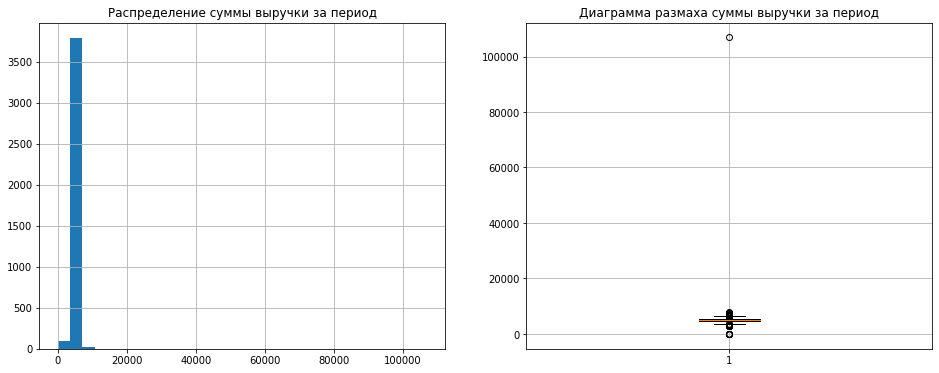

In [48]:
show_graph_1(market_money['выручка'], 'Распределение суммы выручки за период', 'Диаграмма размаха суммы выручки за период')

В данных есть аномалия - значение выручки, больше 100000:

In [49]:
market_money[market_money['выручка'] > 100000]

,id,период,выручка
98,215380,текущий месяц,106862.2


Посмотрим, какую выручку принес клиент в другие месяцы:

In [50]:
market_money[market_money['id'] == 215380]

,id,период,выручка
96,215380,препредыдущий месяц,5051.0
97,215380,предыдущий месяц,6077.0
98,215380,текущий месяц,106862.2


Данные в датафрейме `market_money` представлены по каждому клиенту за три месяца, удаление аномелии может нарушить структуру данных, поэтому заменим аномальное значение медианой:

In [51]:
market_money.loc[market_money['выручка'] > 100000, 'выручка'] = market_money['выручка'].median()

Проверим, как замена аномального значения на медиану сказалась на данных:

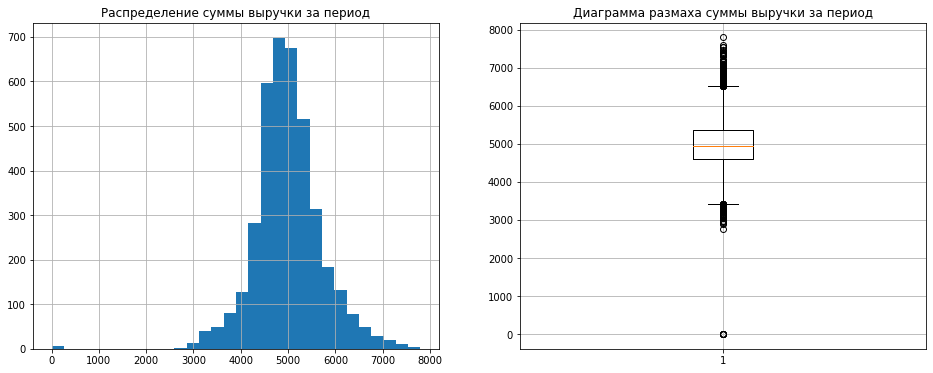

In [52]:
show_graph_1(market_money['выручка'], 'Распределение суммы выручки за период', 'Диаграмма размаха суммы выручки за период')

Имеются выбросы в районе 0, что логично, т.к. некоторые клиенты могут не совершать покупок, поэтому эти значения оставим в датафрейме.

#### Категориальные признаки

Определим категориальные признаки датафрейма `market_money`:

In [53]:
get_columns(market_money)['cat_col_names']

['период']

Проведем исследовательский анализ категориальных данных датафрейма `market_money`.

Отобразим столбчатую и круговую диаграммы для столбца `период`:

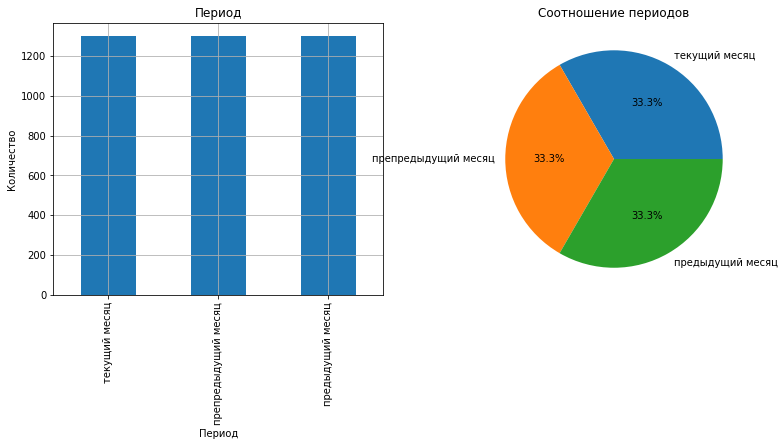

In [54]:
show_graph_2(market_money['период'], 'Период', 'Период', 'Соотношение периодов')

Каждый период в датафрейме представлен в равных долях.

### Датафрейм `market_time`

#### Количественные признаки

Определим количественные признаки датафрейма `market_time`:

In [55]:
get_columns(market_time)['num_col_names']

['id', 'минут']

Проведем исследовательский анализ количественных данных датафрейма `market_time`. Выведем характеристики, дающие представление о выборке (числовое описание данных):

In [56]:
market_time.describe().T

,count,mean,std,min,25%,50%,75%,max
id,2600.0,215997.500000,375.349754,215348.0,215672.75,215997.5,216322.25,216647.0
минут,2600.0,13.336154,4.080198,4.0,10.00,13.0,16.00,23.0


Отобразим гистограмму и "ящик с усами" для столбца `минут`:

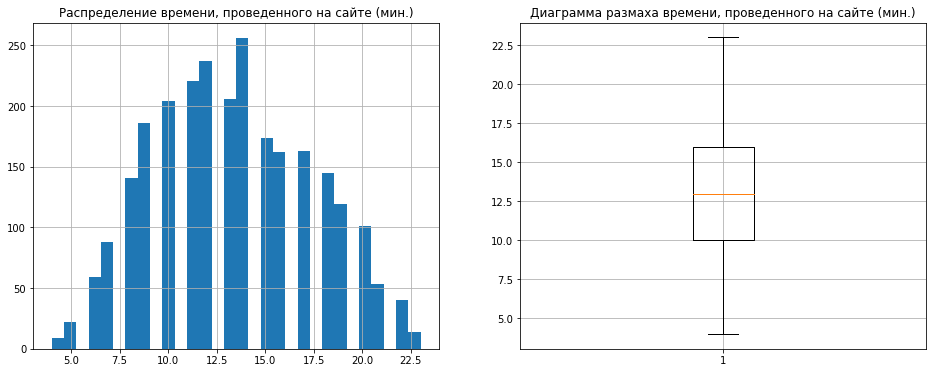

In [57]:
show_graph_1(market_time['минут'], 'Распределение времени, проведенного на сайте (мин.)', 'Диаграмма размаха времени, проведенного на сайте (мин.)')

Распределение похоже на нормальное, все значения находятся в пределах нормы.

#### Категориальные признаки

Определим категориальные признаки датафрейма `market_time`:

In [58]:
get_columns(market_time)['cat_col_names']

['период']

Проведем исследовательский анализ категориальных данных датафрейма `market_time`.

Отобразим столбчатую и круговую диаграммы для столбца `период`:

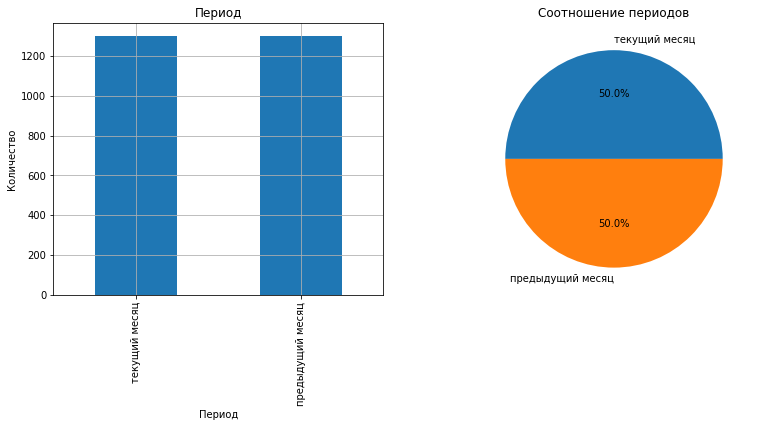

In [59]:
show_graph_2(market_time['период'], 'Период', 'Период', 'Соотношение периодов')

Каждый период в датафрейме представлен в равных долях - по 50%.

### Датафрейм `money`

#### Количественные признаки

Определим количественные признаки датафрейма `money`:

In [60]:
get_columns(money)['num_col_names']

['id', 'прибыль']

Проведем исследовательский анализ количественных данных датафрейма `money`. Выведем характеристики, дающие представление о выборке (числовое описание данных):

In [61]:
money.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1300.0,215997.500000,375.421985,215348.00,215672.75,215997.500,216322.25,216647.00
прибыль,1300.0,3.996631,1.013722,0.86,3.30,4.045,4.67,7.43


Отобразим гистограмму и "ящик с усами" для столбца `прибыль`:

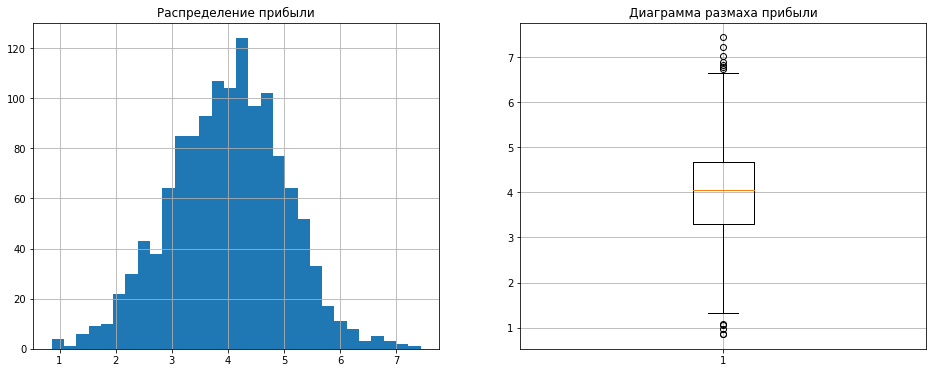

In [62]:
show_graph_1(money['прибыль'], 'Распределение прибыли', 'Диаграмма размаха прибыли')

Распределение прибыли похоже на нормальное, значения незначительно отклоняются от нормы, поэтому значения, выходящие за "усы" на диаграмме размаха, удалять не будем. 

#### Категориальные признаки

Определим категориальные признаки датафрейма `money`:

In [63]:
get_columns(money)['cat_col_names']

[]

Датафрейм `money` не имеет категориальных признаков.

### Отбор пользователей

Отберем клиентов с покупательской активностью не менее трех месяцев (т.е. таких, которые что-либо покупали в этот период):

In [64]:
market_money_pivot = market_money.pivot_table(index='id', columns='период', values='выручка', aggfunc='sum').reset_index()
inactive_id = market_money_pivot[(market_money_pivot['препредыдущий месяц'] == 0) | (market_money_pivot['предыдущий месяц'] == 0) | (market_money_pivot['текущий месяц'] == 0)]['id'].tolist()
inactive_id

[215348, 215357, 215359]

Получилось, что три пользователя не были активны с покупательской точки зрения в течение всех трех месяцев. Найдем их в датафрейме `market_file`: 

In [65]:
market_file[market_file.id.isin(inactive_id)]

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,неоплаченные_продукты_штук_квартал_кат
0,215348,Снизилась,премиум,да,3.4,5,121,0.0,Товары для детей,6,2,1,5,низкий
9,215357,Снизилась,стандарт,да,3.9,5,154,0.0,Техника для красоты и здоровья,3,3,9,5,низкий
11,215359,Снизилась,стандарт,да,4.6,5,110,0.0,Домашний текстиль,4,2,4,2,низкий


Удалим из датафрейма `market_file` пользователей, история активности которых не насчитывает трех месяцев:

In [66]:
market_file = market_file[~market_file.id.isin(inactive_id)]

**Выводы из раздела №3.** Проведен исследовательский анализ данных, в ходе которого проанализированы количественный и категориальные признаки всех четырех датафреймов, в датафрейме `market_money` аномальное значение в столбце `выручка` заменено на медиану, а из датафрейма `market_file` удалены три пользователя, которые не были активны в течение всех трех месяцев. Данные готовы для проведения дальнейшего исследования.

## Объединение таблиц

Объединим таблицы `market_file`, `market_money` и `market_time` (данные о прибыли из таблицы `money` при моделировании не понадобятся). Данные о выручке и времени на сайте находятся в одном столбце для всех периодов, в итоговой таблице сделаем отдельный столбец для каждого периода.

Подготовим сводную таблицу по датафрейму `market_money`:

In [67]:
market_money_pivot = market_money.pivot_table(index='id', columns='период', values='выручка', aggfunc='sum').reset_index()
market_money_pivot.columns = ['id', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц']
market_money_pivot.head()

,id,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
0,215348,0.0,0.0,3293.1
1,215349,5216.0,4472.0,4971.6
2,215350,5457.5,4826.0,5058.4
3,215351,6158.0,4793.0,6610.4
4,215352,5807.5,4594.0,5872.5


Подготовим сводную таблицу по датафрейму `market_time`:

In [68]:
market_time_pivot = market_time.pivot_table(index='id', columns='период', values='минут', aggfunc='sum').reset_index()
market_time_pivot.columns = ['id', 'минут_предыдущий_месяц', 'минут_текущий_месяц']
market_time_pivot.head()

,id,минут_предыдущий_месяц,минут_текущий_месяц
0,215348,13,14
1,215349,12,10
2,215350,8,13
3,215351,11,13
4,215352,8,11


Произведем объединение сводных таблиц с `market_file`:

In [69]:
market_data = market_file.merge(market_money_pivot, on='id', how='left').merge(market_time_pivot, on='id', how='left')
market_data.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,неоплаченные_продукты_штук_квартал_кат,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,низкий,5216.0,4472.0,4971.6,12,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,низкий,5457.5,4826.0,5058.4,8,13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,низкий,6158.0,4793.0,6610.4,11,13
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,низкий,5807.5,4594.0,5872.5,8,11
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,низкий,4738.5,5124.0,5388.5,10,10


Добавим преобразованный целевой признак:

In [70]:
market_data['покупательская_активность_кол'] = market_data['покупательская_активность'].apply(lambda x: 0 if x == 'Снизилась' else 1)

Проверим получившийся датафрейм на наличие пропусков в данных:

In [71]:
market_data.isna().sum()

id                                        0
покупательская_активность                 0
тип_сервиса                               0
разрешить_сообщать                        0
маркет_актив_6_мес                        0
маркет_актив_тек_мес                      0
длительность                              0
акционные_покупки                         0
популярная_категория                      0
средний_просмотр_категорий_за_визит       0
неоплаченные_продукты_штук_квартал        0
ошибка_сервиса                            0
страниц_за_визит                          0
неоплаченные_продукты_штук_квартал_кат    0
выручка_предыдущий_месяц                  0
выручка_препредыдущий_месяц               0
выручка_текущий_месяц                     0
минут_предыдущий_месяц                    0
минут_текущий_месяц                       0
покупательская_активность_кол             0
dtype: int64

Пропусков данных не обнаружено, получившийся датафрейм `market_data` будем использовать в дальнейших шагах исследования.

In [72]:
market_data.shape

(1297, 20)

Проведем дополнительное исследование - выясним, чем активные клиенты отличаются от снижающих активность. 

Разделим данные на две части:
* Произошло снижение покупательской активности
* Покупательская активность осталась на прежнем уровне

In [73]:
activity_down = market_data[market_data['покупательская_активность_кол'] == 0]
activity_unchanged = market_data[market_data['покупательская_активность_кол'] == 1]

Построим распределения по каждому количественному признаку по активным клиентам и клиентам, снижающим активность:

In [74]:
def show_graph_3(df_1, df_2, col_name, label_1, label_2):
    tmp = df_1.plot(
        kind='hist',
        histtype='step',
        linewidth=5,
        alpha=0.7,
        y=col_name,
        bins=50,
        label=label_1,
        grid=True,
        legend=True
    )
    df_2.plot(
        kind='hist',
        ax=tmp,
        histtype='step',
        linewidth=5,
        alpha=0.7,
        y=col_name,
        bins=50,
        label=label_2,
        grid=True,
        legend=True,
        title=f'Распределение признака "{col_name}"'
    )
    plt.legend(bbox_to_anchor=(1, 0.6));

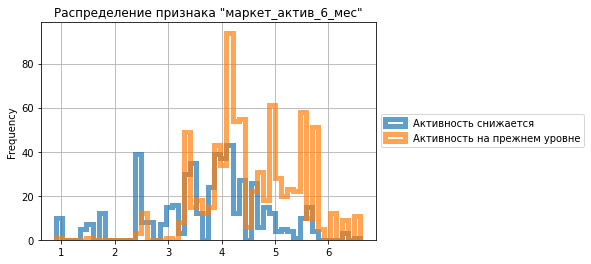

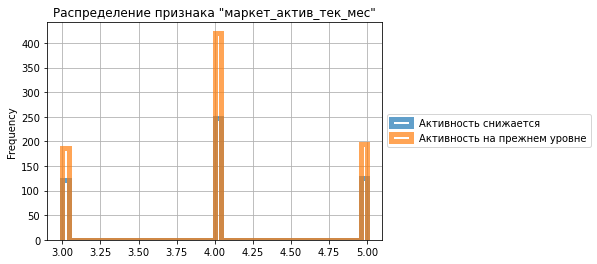

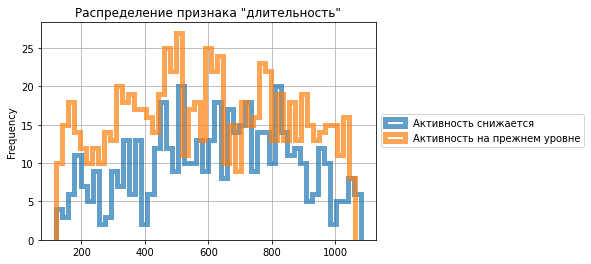

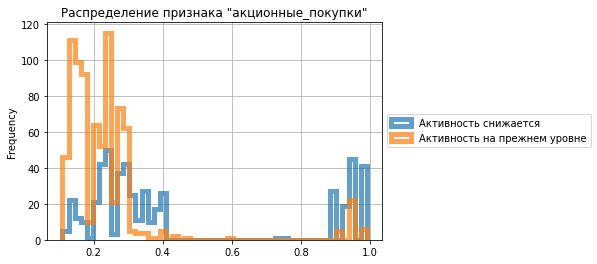

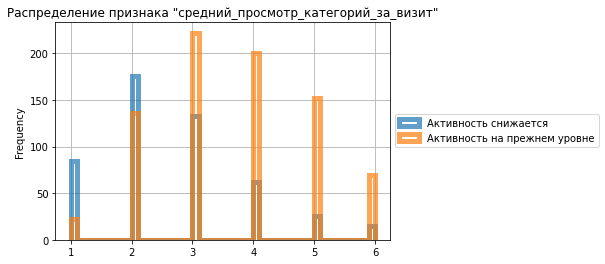

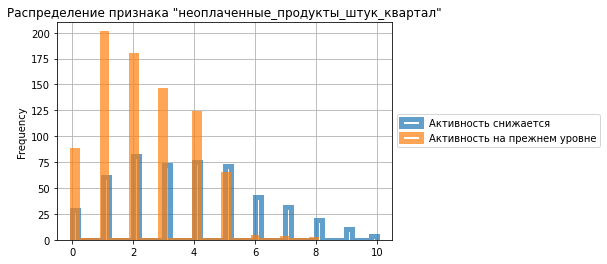

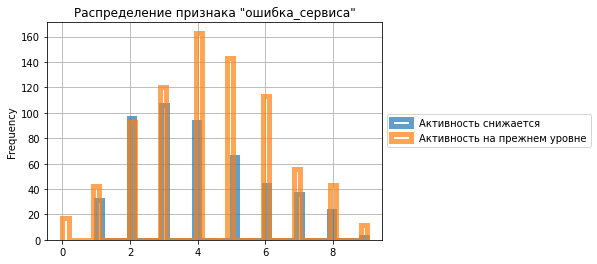

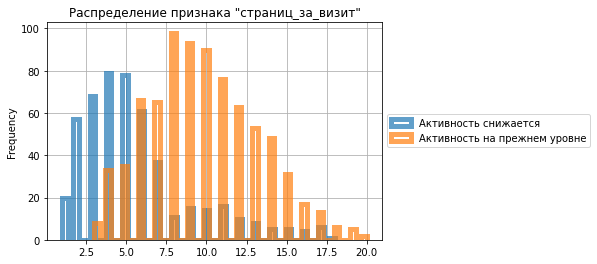

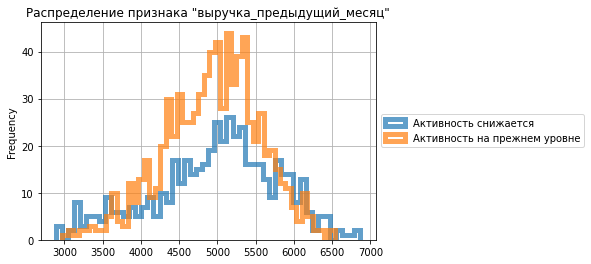

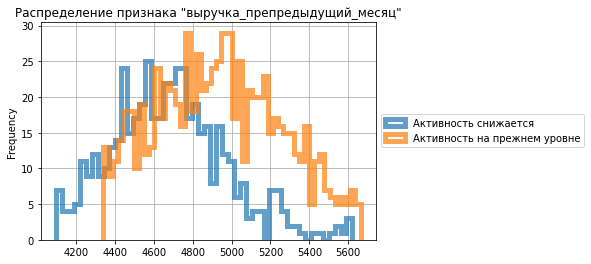

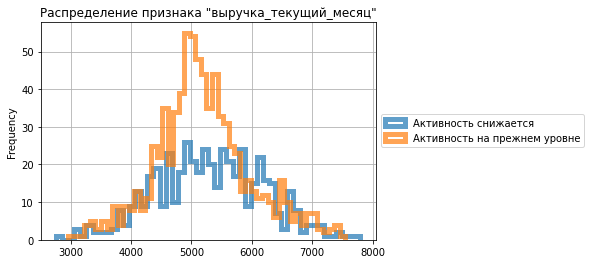

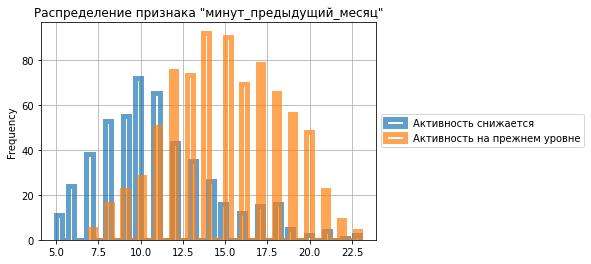

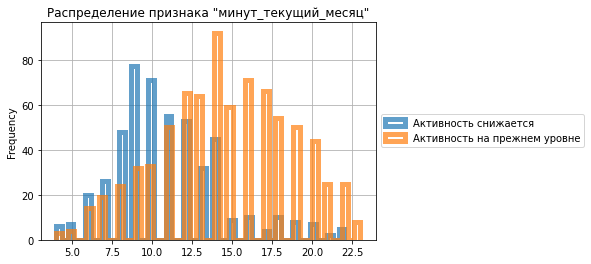

In [75]:
for i in get_columns(market_data.drop(['id', 'покупательская_активность_кол'], axis=1))['num_col_names']:
    show_graph_3(activity_down, activity_unchanged, i, 'Активность снижается', 'Активность на прежнем уровне')

Рассмотрим, в чем отличие активных клиентов от пользователей, снижающих активность:
* На клиентов со снижающейся активностью за последние 6 месяцев приходилось меньше маркетинговых коммуникаций компании, т.е. число рассылок, звонков, показов рекламы и прочего больше на клиентов с активностью на прежнем уровне
* Пользователи с неснижающейся активностью дольше зарегистрированы на сайте, в отличие от тех, активность которых снижается
*  Пользователи со снижающейся активностью в большей части покупают товары по акции, в отличие от пользователей с неснижающейся активностью - у них ниже среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев
* Пользователи со снижающейся активностью в среднем просмотрел за визит в течение последнего месяца просматривают 1-2 категории, пользователей с неснижающейся активностью просматривают больше категорий
* Общее число неоплаченных товаров в корзине за последние 3 месяца больше у пользователей со снижающейся активностью
* Пользователи с неснижающейся активностью во время посещения сайта чаще сталкиваются со сбоями (видимо, потому что эта группа пользователей больше)
* Пользователи со снижающейся активностью в среднем за последние 3 месяца за визит просматривают меньшее количество страниц (до 5-ти), в то время как клиенты с активностью на прежнем уровне просматривают больше страниц (до 10-11)
* За 3 месяца произошло смещение выручки, приносимой пользователями: в препредыдущий месяц пользователи с неснижающейся активностью давали выручки в большинстве случаев 4800-5000, пользователи со внижающейся активностью - 4400-4800. В предыдущий месяц выручка выросла у обеих групп пользователей - до 5000-5400 у первых и у вторых. В текущем месяце произошло снова смещение - до 5000 у первой группы, вторая группа - 4500-6100.
* Пользователи с неснижающейся активностью что в прошлом месяце, что в текущем, проводят больше времени на сайте (13-15 минут), нежели пользователи со снижающейся активностью (9-10 минут)

Также рассмотрим, какие предпочтения в категориях товаров у двух групп пользователей:

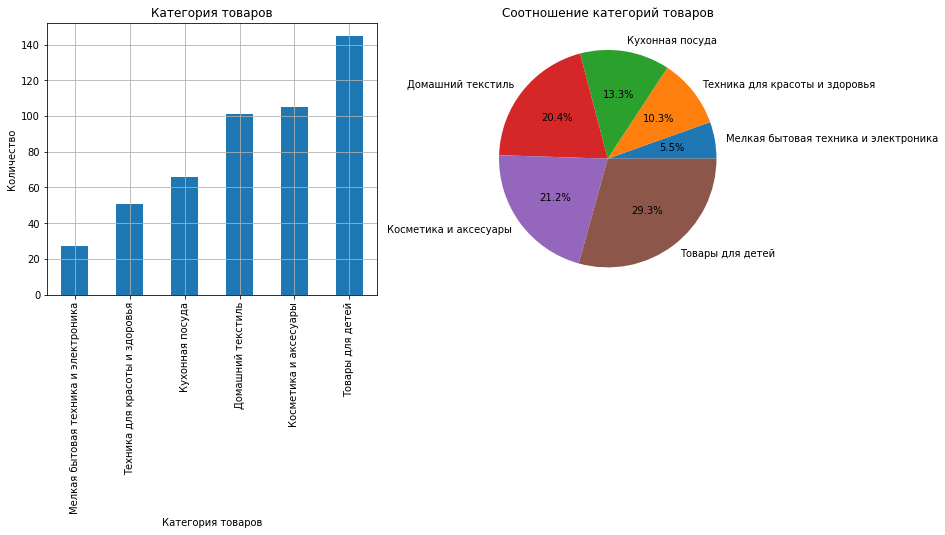

In [76]:
show_graph_2(activity_down['популярная_категория'], 'Категория товаров', 'Категория товаров', 'Соотношение категорий товаров')

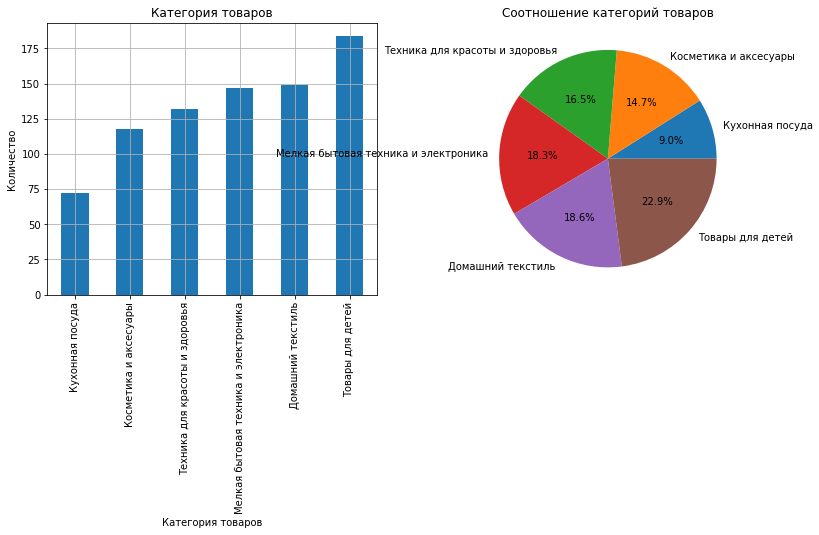

In [77]:
show_graph_2(activity_unchanged['популярная_категория'], 'Категория товаров', 'Категория товаров', 'Соотношение категорий товаров')

У обеих групп пользователей преобладающая категория товаров - "Товары для детей". Пользователи со снижающейся активностью неохотно покупают товары категории "Мелкая бытовая техника и электроника", в то время как данная категория на третьем месте у пользователей с неснижающейся активностью. Можно сделать вывод, что пользователи со снижающейся активностью предпочитают в целом недорогие товары, в отличие от пользователей, активность которых сохраняется на прежнем уровне.

## Корреляционный анализ

Создадим функции для отображения тепловой карты корреляционной матрицы:

In [78]:
def get_cm_plot(df):
    phik_matrix = df.drop('id', axis=1).phik_matrix(interval_cols=get_columns(df)['num_col_names'])
    plot_correlation_matrix(phik_matrix.values,
                        x_labels=phik_matrix.columns,
                        y_labels=phik_matrix.index,
                        vmin=0,
                        vmax=1,
                        color_map='Reds',
                        title=r'Тепловая карта корреляционной матрицы $\phi_K$',
                        fontsize_factor=1.5,
                        figsize=(20, 15),
                        identity_layout=False
                       )

Проведем корреляционный анализ признаков в количественной шкале в датафрейме для моделирования `market_data`. Для начала рассчитаем коэффициенты корреляции между всеми количественными признаками и отобразим матрицу корреляций с помощью тепловой карты:

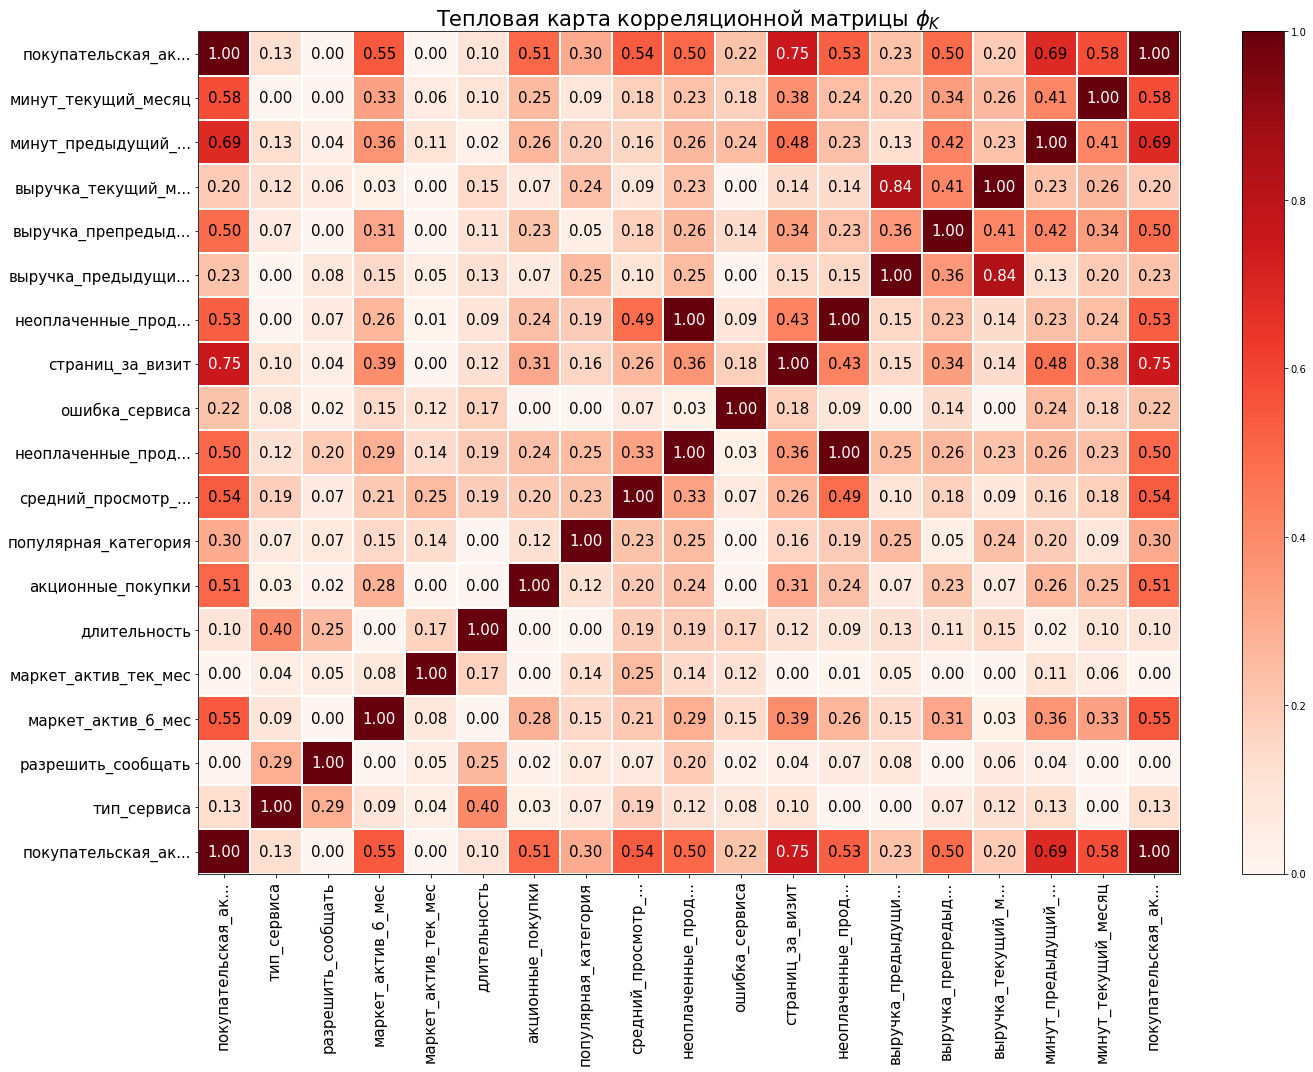

In [79]:
get_cm_plot(market_data)

Темные тона тепловой карты говорят о сильной линейной зависимости, а светлые - о слабой. Судя по тепловой карте, самая сильная прямая связь с целевым признаком `покупательская_активность` у входных признаков `страниц_за_визит`, `минут_предыдущий_месяц` и `минут_текущий_месяц`, а также с количественным целевым признаком `покупательская_активность_кол`. При этом целевой признак `покупательская_активность` не связан с признаками `разрешить_сообщать` и `маркет_актив_тек_мес`. Удалим из датафрейма `market_data` признаки, у которых с слабая зависимость с целевым (меньше 0.15):

In [80]:
del_col = [
    'разрешить_сообщать',
    'маркет_актив_тек_мес',
    'длительность',
    'тип_сервиса'
]
market_data = market_data.drop(del_col, axis=1, errors='ignore')

Проверим признаки на мультиколлинеарность, для этого снова построим тепловую карту корреляционной матрицы:

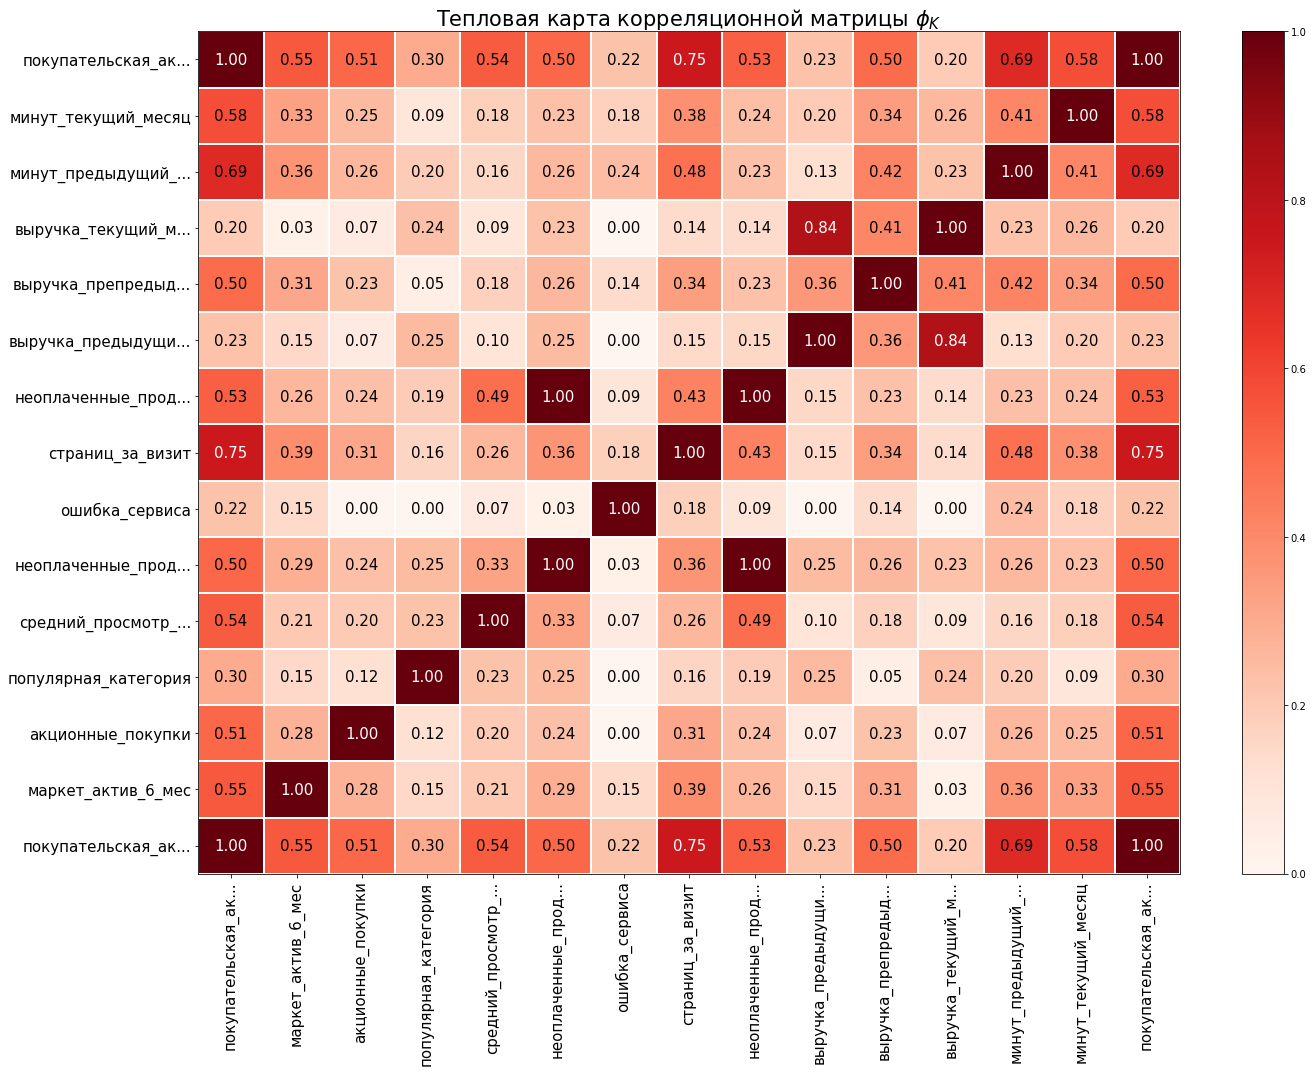

In [81]:
get_cm_plot(market_data)

По тепловой карте видна одна пара сильно коррелирующих признаков - `неоплаченные_продукты_штук_квартал` и `неоплаченные_продукты_штук_квартал_кат` (коэффициент корреляции 1). Уберем из датафрейма менее детализированный признак - `неоплаченные_продукты_штук_квартал`, а также категориальный целевой признак `покупательская_активность`:

In [82]:
market_data = market_data.drop(['неоплаченные_продукты_штук_квартал', 'покупательская_активность'], axis=1, errors='ignore')

Еще раз построим тепловую карту корреляционной матрицы по полученному датафрему:

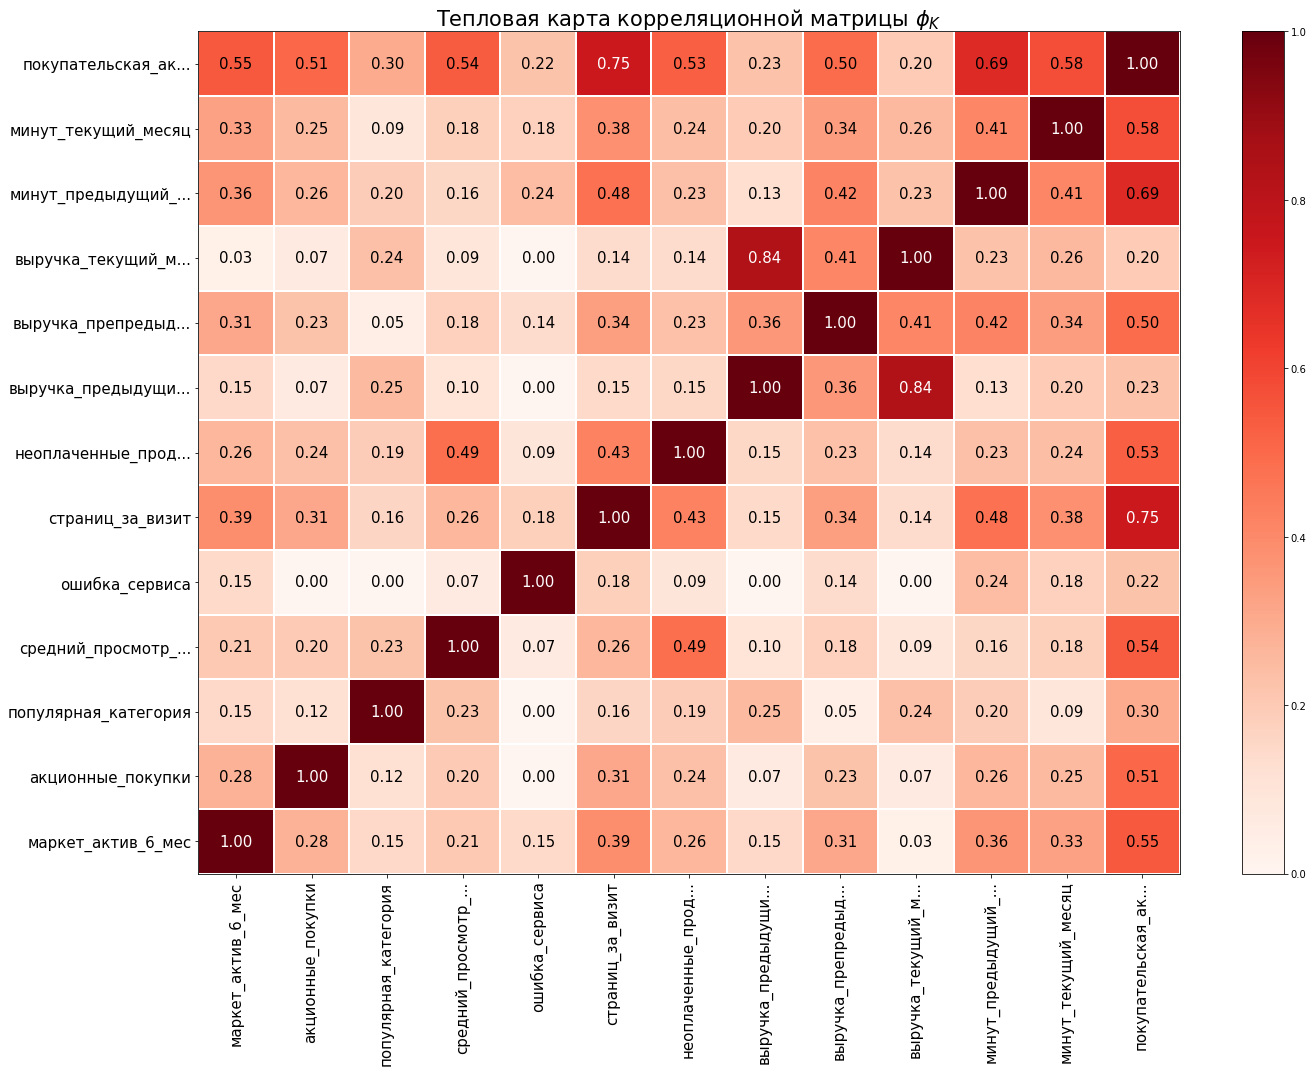

In [83]:
get_cm_plot(market_data)

Теперь отсутствуют признаки, не связанные с целевым, и устранена мультиколлинеарность между признаками - данные можно использовать в модели.

## Моделирование с использованием пайплайнов

Используя пайплайны применим следующие модели:
* Метод k-ближайших соседей (kNN)
* Модель Decision Tree (дерево решений)
* Логистическая регрессия
* Метод опорных векторов (Support Vector Machine - SVM)

Зададим константы:

In [84]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

Разделим данные на тренировочную и тестовую выборки:

In [85]:
X_train, X_test, y_train, y_test = train_test_split(
    market_data.drop(['id', 'покупательская_активность_кол'], axis=1),
    market_data['покупательская_активность_кол'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = market_data['покупательская_активность_кол'])
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((972, 12), (972,), (325, 12), (325,))

Создадим списки с названиями признаков:

In [86]:
ohe_columns = ['популярная_категория']
ord_columns = get_columns(market_data.drop(['id', 'популярная_категория', 'покупательская_активность_кол'], axis=1))['cat_col_names']
num_columns = get_columns(market_data.drop(['id', 'популярная_категория', 'покупательская_активность_кол'], axis=1))['num_col_names']

Создадим пайплайны для подготовки признаков:

In [87]:
ohe_pipe = Pipeline([
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

In [88]:
ord_pipe = Pipeline([
    ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ord', OrdinalEncoder(categories=[['низкий', 'высокий']], handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

In [89]:
num_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(2)),
    ('minmax', MinMaxScaler())
])

Создадим общий пайплайн для обработки данных:

In [90]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', num_pipe, num_columns)
    ], 
    remainder='passthrough'
)

Создадим итоговый пайплайн - подготовка данных и модель:

In [91]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

Создадим словарь со значениями гиперпараметров:

In [92]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        #'models__min_samples_leaf': range(1, 6),
        #'models__min_samples_split': range(2, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE)],
        'models__kernel': ['linear', 'rbf', 'sigmoid', 'poly'],
        'models__degree': range(2, 7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

Для поиска лучшей модели будем использовать RandomizedSearchCV - наиболее быстрый и точный способ. Метрику будем использовать ROC-AUC, т.к. важны как Precision, так и Recall.

In [93]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и ее параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и ее параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent'...
    

На тренировочных данных лучше всех себя показала модель логистической регрессии, метрика ROC-AUC - 0.9066. Проверим работу модели на тестовой выборке:

In [94]:
probabilities = randomized_search.best_estimator_.named_steps['models'].predict_proba(
    randomized_search.best_estimator_['preprocessor'].transform(X_test)
)
probabilities_one = probabilities[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(y_test, probabilities_one))

Площадь ROC-кривой: 0.8882201893757021


На тестовой выборке модель также показала хороший результат - метрика ROC-AUC равна 0.8882.

## Анализ важности признаков

Проведем оценку важности признаков для лучшей модели.

Лучшая модель:

In [95]:
best_model = randomized_search.best_estimator_.named_steps['models']

Данные, на которых модель обучалась:

In [96]:
preprocessor = randomized_search.best_estimator_['preprocessor']
X_train_preprocessor = preprocessor.transform(X_train)
features_names = (list(preprocessor['ohe'].get_feature_names_out()) +
                  list(preprocessor['ord'].get_feature_names_out()) +
                  list(preprocessor['num'].get_feature_names_out()))
X = pd.DataFrame(X_train_preprocessor, columns=features_names)
X.head()

,популярная_категория_Косметика и аксесуары,популярная_категория_Кухонная посуда,популярная_категория_Мелкая бытовая техника и электроника,популярная_категория_Техника для красоты и здоровья,популярная_категория_Товары для детей,неоплаченные_продукты_штук_квартал_кат,маркет_актив_6_мес,акционные_покупки,средний_просмотр_категорий_за_визит,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
0,0.0,0.0,1.0,0.0,0.0,0.0,0.728190,-0.685512,1.285055,0.432871,1.224004,-1.299601,0.293763,-2.248983,1.380925,0.646596
1,0.0,0.0,0.0,0.0,0.0,0.0,-0.157176,-0.242856,-0.936178,-0.076512,1.224004,-0.050609,1.437146,-0.665092,0.880549,-0.529473
2,0.0,0.0,0.0,0.0,1.0,0.0,-1.239290,2.292353,-0.195767,1.451639,-1.041673,0.448702,-0.361737,0.498154,-1.371144,-0.999900
3,0.0,0.0,0.0,0.0,1.0,0.0,-0.157176,2.453319,1.285055,-0.585896,-0.286447,-0.554914,-1.053154,-0.965171,-1.621332,-1.470328
4,0.0,0.0,0.0,1.0,0.0,0.0,2.007053,-0.806236,-0.195767,0.432871,-0.286447,-0.022790,-0.331805,0.001669,1.130737,-1.470328


Построим график важности признаков по величине коэффициентов:

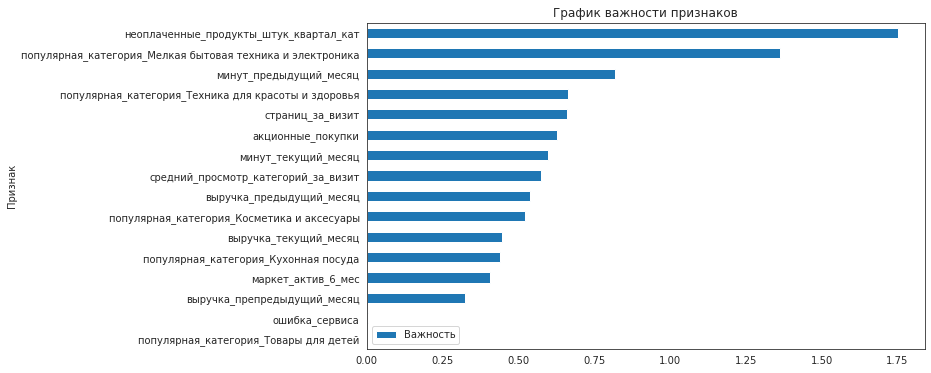

In [97]:
coefficients = best_model.coef_[0]
sns.set_style('white')
feature_importance = pd.DataFrame({'Признак': X.columns, 'Важность': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Важность', ascending=True)
feature_importance.plot(x='Признак', y='Важность', kind='barh', figsize=(10, 6), title='График важности признаков');

По графику видно, что далеко не все признаки важны для модели. Есть те, которые вносят мало информации - например, `популярная_категория_Товары для детей` и `ошибка_сервиса`. Наиболее значимым для модели является признак `неоплаченные_продукты_штук_квартал_кат`.

Произведем оценку вклада признака в каждый прогноз с помощью значений Шепли методом SHAP (SHapley Additive exPlanations) - вычислим, как отдельный признак помог присвоить модели итоговое значение целевого:

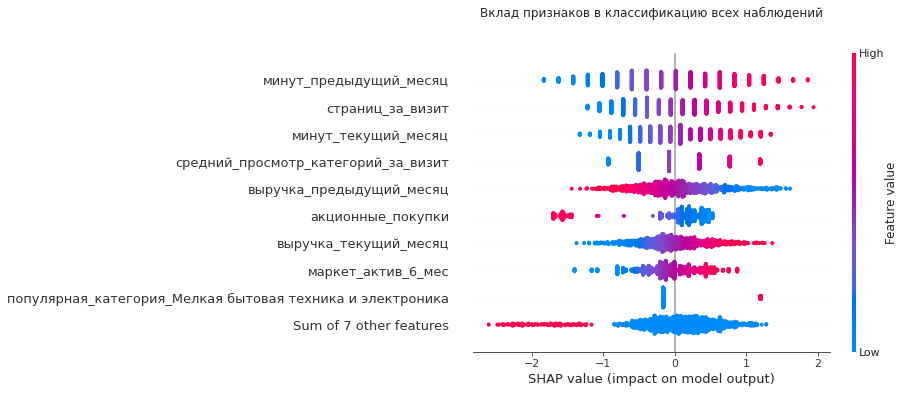

In [98]:
plt.title('Вклад признаков в классификацию всех наблюдений', y=1.1)
explainer = shap.LinearExplainer(best_model, X)
shap_values = explainer(X)
shap.plots.beeswarm(shap_values)
plt.show()

Выводы из графика SHAP:
* Чем больше времени пользователи проводят на сайте, чем больше они просматривают страниц и чем выше значения просмотра категорий за визит, тем выше вероятность принадлежности к классу 1 (активность осталась на прежнем уровне)
* Чем выше показатель акционных покупок, тем ниже активность - видимо, сказывается потеря интереса пользователей, ожидающих скидки при завершении акций
* Большое количество маркетинговых коммуникаций положительно влияют на активность пользователей
* Большой размер выручки также положительно влияет на вероятность того, что активность на сайте не снизится

В целом, данные выводы сходятся с теми, что были описаны ранее при проведении исследовательского анализа в пункте с объединением таблиц.

Для увеличения активности пользователей руководству интернет-магазина можно порекомендовать следующее:
* Стимулировать пользователей заходить на сайт и проводить на нем продолжительное время
* Проводить различные маркетинговые активности для привлечения и удержания пользователей
* Создавать систему акций и скидок как для новых пользователей, так и для постоянных клиентов
* Увеличить ассортимент продаваемых товаров
* Реализовать или улучшить рекомендательную систему для стимулирования покупки товаров

## Сегментация покупателей

Для проведения сегментации покупателей сформируем общий датафрейм из таблиц `market_data` и `money`:

In [99]:
segmentation_data = market_data.merge(money, on='id', how='left')
segmentation_data.head()

,id,маркет_актив_6_мес,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,ошибка_сервиса,страниц_за_визит,неоплаченные_продукты_штук_квартал_кат,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,покупательская_активность_кол,прибыль
0,215349,4.4,0.75,Товары для детей,4,2,5,низкий,5216.0,4472.0,4971.6,12,10,0,4.16
1,215350,4.9,0.14,Домашний текстиль,5,1,5,низкий,5457.5,4826.0,5058.4,8,13,0,3.13
2,215351,3.2,0.99,Товары для детей,5,6,4,низкий,6158.0,4793.0,6610.4,11,13,0,4.87
3,215352,5.1,0.94,Товары для детей,3,3,2,низкий,5807.5,4594.0,5872.5,8,11,0,4.21
4,215353,3.3,0.26,Домашний текстиль,4,1,4,низкий,4738.5,5124.0,5388.5,10,10,0,3.95


Определим признаки, влияющие на прибыль интернет-магазина от продаж каждому покупателю, для чего построим матрицу корреляции:

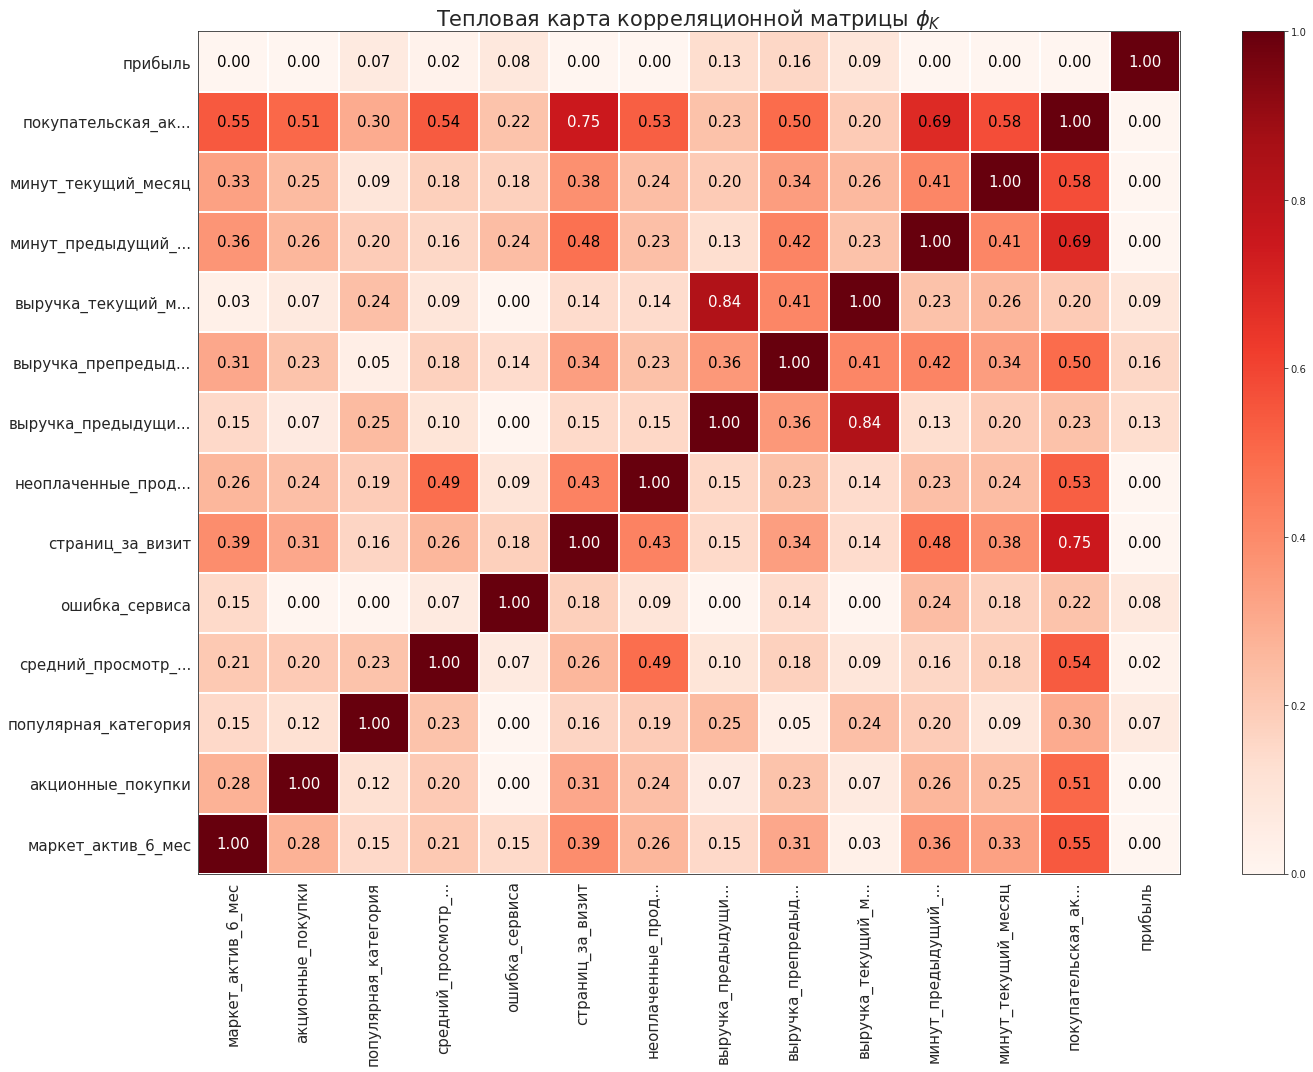

In [100]:
get_cm_plot(segmentation_data)

Получается, что прибыль слабо коррелирует со всеми признаками в датафрейме, имеется чуть более высокая корреляция с признаками выручки. С помощью лучшей модели получим вероятности снижения покупательской активности:

In [101]:
proba = randomized_search.predict_proba(
    segmentation_data.drop(['id', 'покупательская_активность_кол', 'прибыль'], axis=1)
)[:,0]
segmentation_data['вероятность_снижения_активности'] = proba
segmentation_data.head()

,id,маркет_актив_6_мес,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,ошибка_сервиса,страниц_за_визит,неоплаченные_продукты_штук_квартал_кат,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,покупательская_активность_кол,прибыль,вероятность_снижения_активности
0,215349,4.4,0.75,Товары для детей,4,2,5,низкий,5216.0,4472.0,4971.6,12,10,0,4.16,0.911797
1,215350,4.9,0.14,Домашний текстиль,5,1,5,низкий,5457.5,4826.0,5058.4,8,13,0,3.13,0.589826
2,215351,3.2,0.99,Товары для детей,5,6,4,низкий,6158.0,4793.0,6610.4,11,13,0,4.87,0.921224
3,215352,5.1,0.94,Товары для детей,3,3,2,низкий,5807.5,4594.0,5872.5,8,11,0,4.21,0.981744
4,215353,3.3,0.26,Домашний текстиль,4,1,4,низкий,4738.5,5124.0,5388.5,10,10,0,3.95,0.708375


Отобразим зависимость прибыли от вероятности снижения покупательской активности:

In [102]:
def show_graph_4(x, y, xlabel, ylabel, title):
    plt.figure(figsize=(11, 8))
    plt.scatter(x=x, y=y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.show()

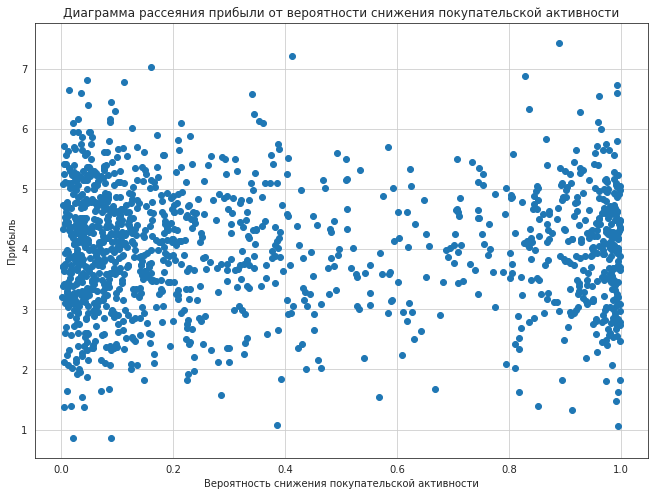

In [103]:
show_graph_4(segmentation_data['вероятность_снижения_активности'],
             segmentation_data['прибыль'],
             'Вероятность снижения покупательской активности',
             'Прибыль',
             'Диаграмма рассеяния прибыли от вероятности снижения покупательской активности'
            )

Интернет-магазину необходимо обратить пристальное внимание на сегмент покупателей, с большой вероятностью снижения активности и приносимой высокой прибылью. Проанализируем данный сегмент и определим, как увеличить его покупательскую активность. Возьмем следующий срез покупателей:

In [104]:
segmentation_data_slice = segmentation_data[(segmentation_data['прибыль'] > 2) & (segmentation_data['вероятность_снижения_активности'] > 0.7)]
segmentation_data_slice.head()

,id,маркет_актив_6_мес,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,ошибка_сервиса,страниц_за_визит,неоплаченные_продукты_штук_квартал_кат,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,покупательская_активность_кол,прибыль,вероятность_снижения_активности
0,215349,4.4,0.75,Товары для детей,4,2,5,низкий,5216.0,4472.0,4971.6,12,10,0,4.16,0.911797
2,215351,3.2,0.99,Товары для детей,5,6,4,низкий,6158.0,4793.0,6610.4,11,13,0,4.87,0.921224
3,215352,5.1,0.94,Товары для детей,3,3,2,низкий,5807.5,4594.0,5872.5,8,11,0,4.21,0.981744
4,215353,3.3,0.26,Домашний текстиль,4,1,4,низкий,4738.5,5124.0,5388.5,10,10,0,3.95,0.708375
5,215354,5.1,0.23,Косметика и аксесуары,2,7,2,низкий,5685.0,4503.0,5869.6,11,12,0,3.62,0.789915


С помощью матрицы корреляции определим показатели, влияющие на целевой признак `покупательская_активность_кол`:

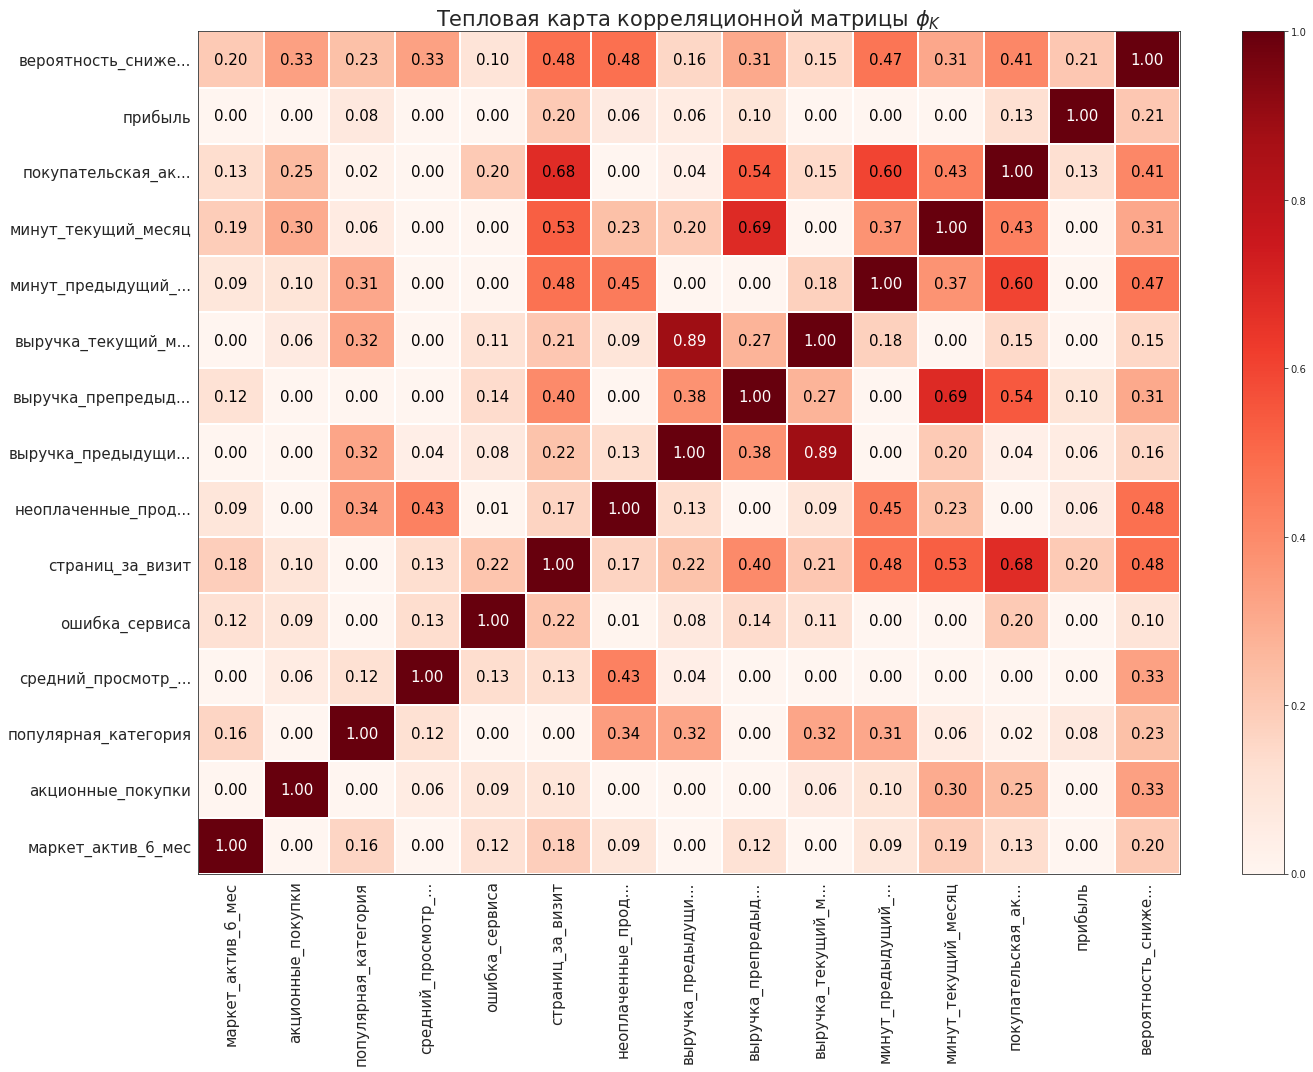

In [105]:
get_cm_plot(segmentation_data_slice)

Построим диаграммы рассеяния для целевого признака `вероятность_снижения_активности` со всеми коррелирующими признаками:

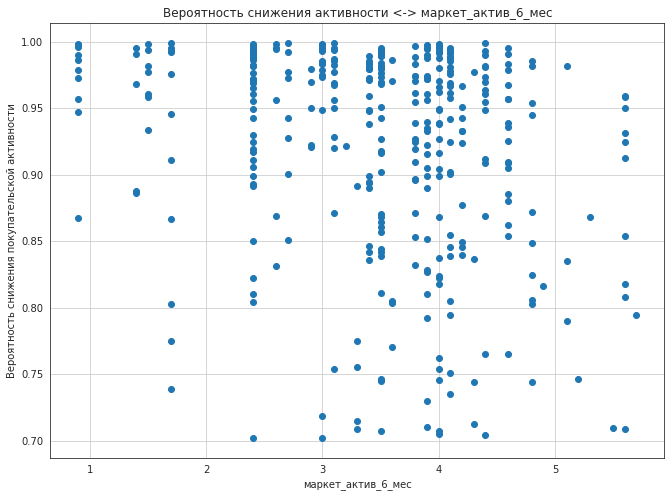

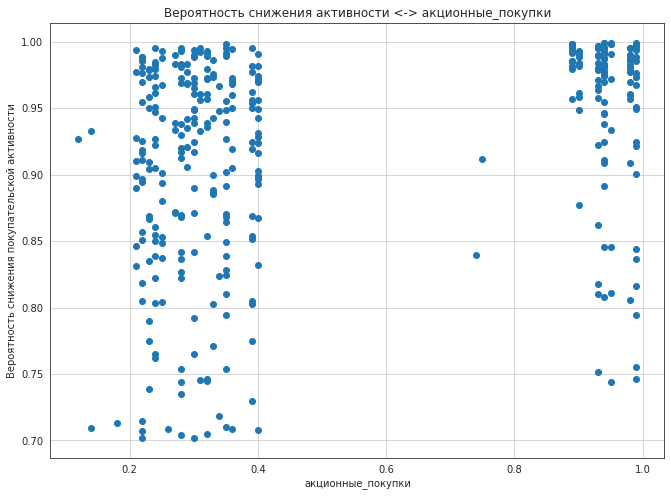

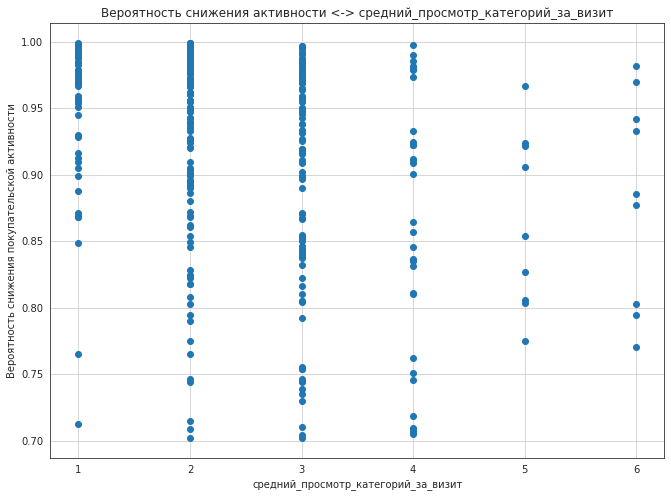

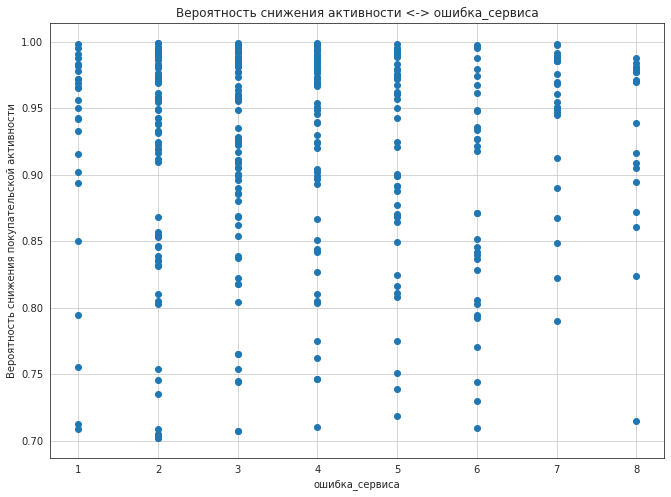

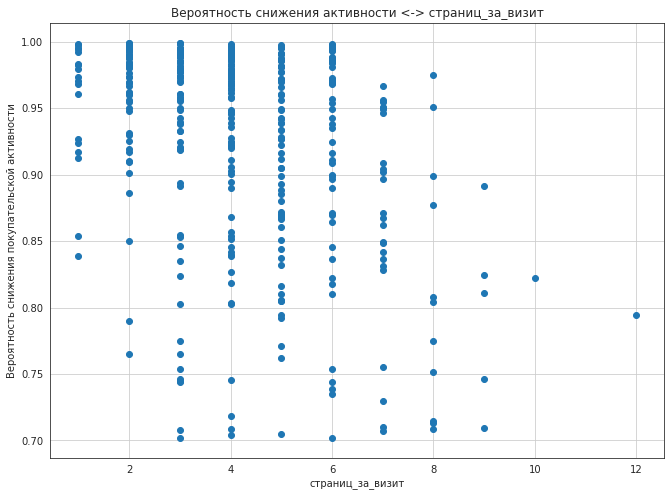

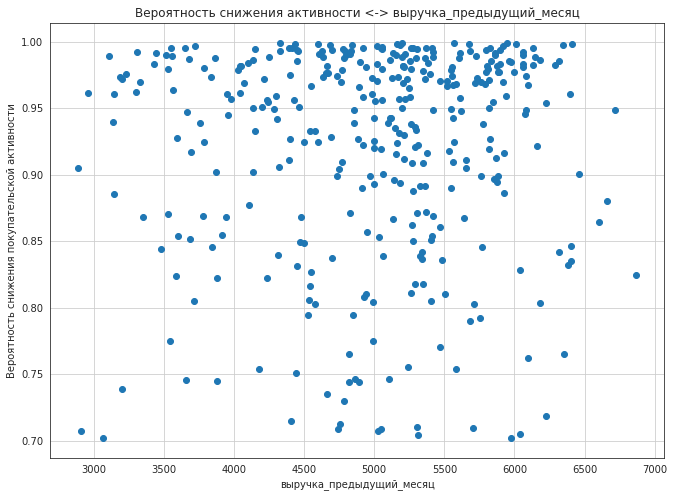

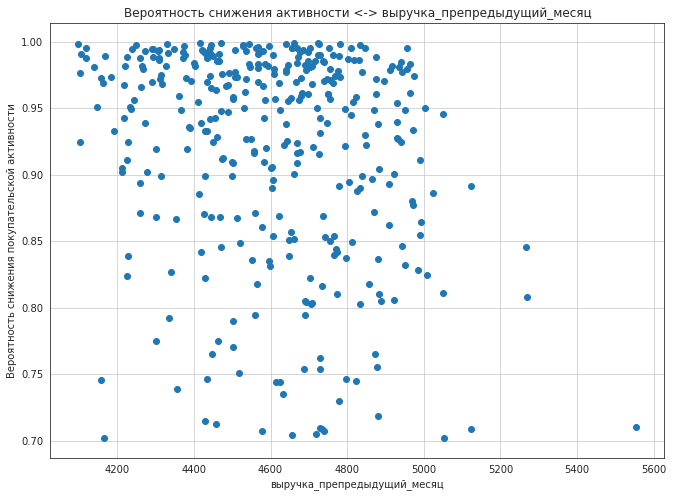

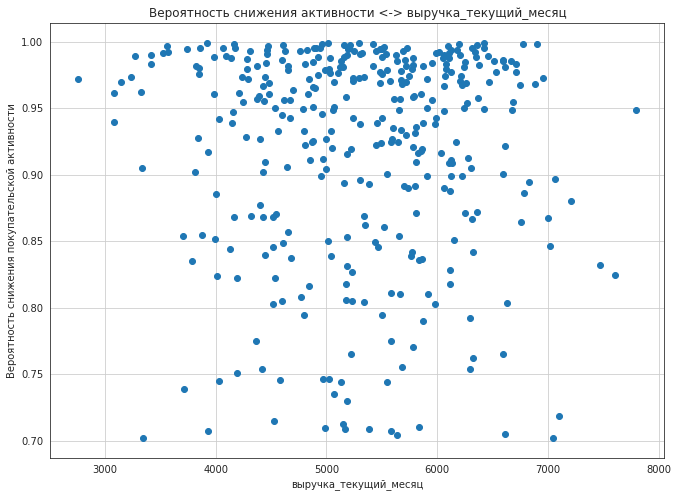

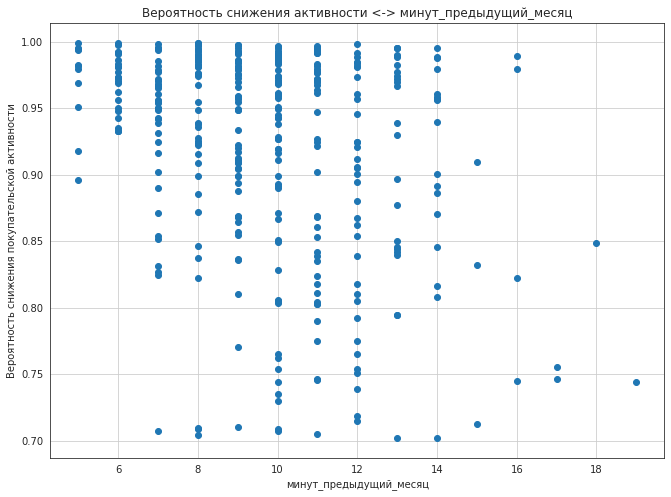

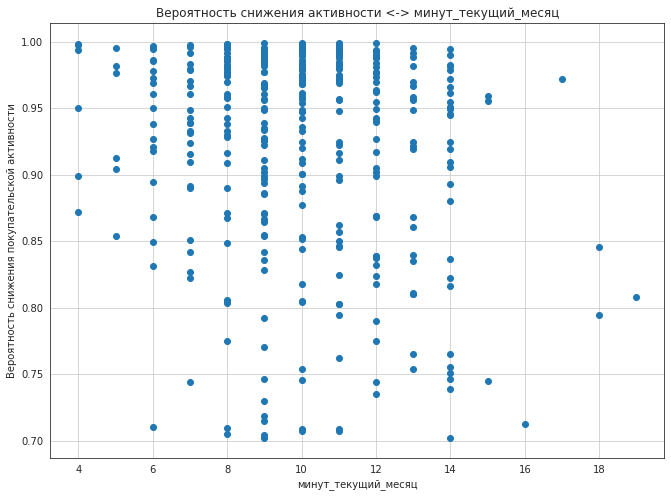

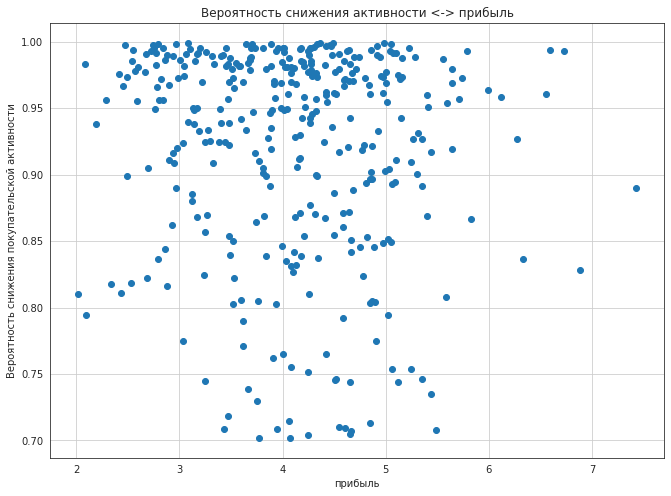

In [106]:
col_list = get_columns(segmentation_data_slice.drop(
    ['id', 'покупательская_активность_кол', 'вероятность_снижения_активности'], axis=1
))['num_col_names']
for i in col_list:
    show_graph_4(segmentation_data_slice[i],
                 segmentation_data_slice['вероятность_снижения_активности'],
                 i,
                 'Вероятность снижения покупательской активности',
                 f'Вероятность снижения активности <-> {i}'
                )

По диаграммам рассеяния конкретных выводов сделать нельзя, кроме того, что имеется большая вероятность снижения активности, если доля акционных покупок составялет 90%.

Проанализируем, как в проблемной группе пользователей распределены вероятности снижения активности по категориям товаров:

In [107]:
segmentation_data_slice.pivot_table(
    index='популярная_категория',
    values='вероятность_снижения_активности',
    aggfunc='mean'
).reset_index().sort_values(by='вероятность_снижения_активности', ascending=False)

,популярная_категория,вероятность_снижения_активности
5,Товары для детей,0.933193
0,Домашний текстиль,0.926574
2,Кухонная посуда,0.919108
1,Косметика и аксесуары,0.908517
4,Техника для красоты и здоровья,0.891626
3,Мелкая бытовая техника и электроника,0.885896


Получилось, что в группе таких пользователей наибольшая вероятность снижения активности у тех, у кого популярной категорией является "Товары для детей", наименьшая вероятность у тех, кто предпочитает "Мелкая бытовая техника и электроника".

Посчитаем выручку по периодам в разрезе популярных категорий в проблемной группе пользователей:

In [132]:
segmentation_data_slice.pivot_table(
    index='популярная_категория',
    values=['выручка_препредыдущий_месяц', 'выручка_предыдущий_месяц', 'выручка_текущий_месяц'],
    aggfunc='sum'
).reset_index()[[
    'популярная_категория',
    'выручка_препредыдущий_месяц',
    'выручка_предыдущий_месяц',
    'выручка_текущий_месяц'
]]

,популярная_категория,выручка_препредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц
0,Домашний текстиль,331933.0,372221.0,394604.4
1,Косметика и аксесуары,367678.0,418760.0,445997.6
2,Кухонная посуда,240968.0,279216.5,300658.7
3,Мелкая бытовая техника и электроника,59696.0,69362.0,72753.7
4,Техника для красоты и здоровья,141849.0,135148.0,140899.1
5,Товары для детей,524078.0,532329.0,564835.5


У всех категорий за квартал выручка имеет постоянный рост, кроме категории "Техника для красоты и здоровья" - во втором месяце было падение с 141849 до 135148, и в текущем месяце показатель выручки не дотянул до значения начала периода и составил 140899.

Рассмотрим другие показатели по категориям в проблемной группе пользователей:

In [147]:
segmentation_data_slice.pivot_table(
    index='популярная_категория',
    values=[
        'акционные_покупки',
        'средний_просмотр_категорий_за_визит',
        'маркет_актив_6_мес',
        'ошибка_сервиса',
        'минут_предыдущий_месяц',
        'минут_текущий_месяц',
        'прибыль',
        'страниц_за_визит'
    ],
    aggfunc='mean'
).reset_index()

,популярная_категория,акционные_покупки,маркет_актив_6_мес,минут_предыдущий_месяц,минут_текущий_месяц,ошибка_сервиса,прибыль,средний_просмотр_категорий_за_визит,страниц_за_визит
0,Домашний текстиль,0.509722,3.266667,10.180556,9.680556,4.013889,3.944444,2.652778,4.180556
1,Косметика и аксесуары,0.494500,3.513750,9.762500,9.800000,3.987500,4.161250,2.175000,4.487500
2,Кухонная посуда,0.549423,3.507692,10.423077,10.384615,3.692308,3.969038,2.519231,4.134615
3,Мелкая бытовая техника и электроника,0.492308,3.638462,8.538462,8.461538,3.923077,4.270000,2.153846,3.769231
4,Техника для красоты и здоровья,0.522258,3.280645,11.548387,11.483871,3.580645,4.157097,2.354839,4.387097
5,Товары для детей,0.540263,3.634211,8.912281,9.833333,3.798246,4.161053,2.561404,4.131579


По категории "Техника для красоты и здоровья" можно увидеть, что у нее один из самых высоких показателей доли акционных покупок (52%), причем число маркетинговых коммуникаций одно из самых маленьких. Пользователи, предпочитающие покупки в данной категории больше всего времени проводят на сайте (11.5 минут). Возможно, по данной категории была акционная распродажа, но в данной категории много товарав и пользователи не могут быстро найти нужный товар.

По итогам сегментации пользователей можно сделать следующие выводы:
* Пользователи, совершающие большое количество покупок по акции, в дальнейшем могут снижать активность
* Чем ниже количество просматриваемых пользователем категорий, тем выше вероятность снижения активности
* Ошибки сервиса не способоствуют пользовательской активности
* Чем меньше пользователь просматривает страниц, тем выше вероятность снижения активности
* Даже пользователи, приносящие интернет-магазину большую выручку, могут снижать свою активность
* Малое количество времени, проводимого на сайте, способствует снижению активности
* Каждая категория товаров имеет свою вероятность снижения активности у пользователей
* В целом выбранный сегмент характеризуется хорошими показателями выручки, но в будущем может снизить свою активность
* Имеются категории, которые "проседают" по некоторым показателям

Рекомендации для интернет-магазина:
* Различные маркетинговые взаимодействия (звонки, реклама), проводимые компанией, имеют эффект, поэтому интернет-магазину можно и дальше использовать данный инструмент в своей работе
* Проведение различных акций дает свою пользу в виде стимулирования покупок пользователями, но имеются и такие, кто покупает только товары по акции и после завершения акции магазин им становится не интересен - таких пользователей необходимо привлекать и к покупкам товаров без акций, применять методы удержания и стимулирования будущих покупок
* Уменьшение количества ошибок на сайте также положительно скажется на активности и лояльности пользователей
* Особое внимание стоит обращать на пользователей проблемных сегментов, например, клиенты, покупающие все только по акции, или те, по которым предвидится снижение активности - с такими группами клиентов следует проводить работы по удержанию и стимулированию к покупкам
* Расширение категорий и номенклатуры товаров, продаваемых на сайте, особенно в тех категориях, которые имеют большую популярноть у пользователей

## Итоговые выводы

В рамках исследования было необходимо проанализировать данные, предоставленные интернет-магазином «В один клик» о снижении активности покупателей и разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

Интернет-магазин предоставил исходные данные в виде четырех датасетов:
1. Данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении
2. Данные о выручке, которую получает магазин с покупателя
3. Данные о времени, которое покупатель провел на сайте в течение периода
4. Данные о среднемесячной прибыли, которую получает магазин от продаж каждому покупателю

В ходе предобработки данных были переименованы столбцы, произведена проверка на наличие пропусков в данных, обработаны неявные дубликаты.

Был проведен исследовательский анализ данных, в ходе которого проверены качественные и количественные признаки, удалены аномалии и на основе количественного признака добавлен новый категориальный признак.

В ходе корреляционного анализа признаков была устранена сильная линейная зависимость признаков с таргетом, а также устранена мультиколлинеарность между признаками.

Для поиска лучшей модели были использованы пайплайны с различными гиперпараметрами для следующих моделей:
* Метод k-ближайших соседей (kNN)
* Модель Decision Tree (дерево решений)
* Логистическая регрессия
* Метод опорных векторов (Support Vector Machine - SVM)

В качестве лучшей модели была выбрана логистическая регрессия, ее метрика ROC-AUC на тренировочных данных составила 0.9066, а на тестовой выборке - 0.8882.

Для анализа был выбран сегмент покупателей, где клиенты имеют наибольшую вероятность снизить активность и при этом имеют наибольшую потенциальную прибыль.

По результатам анализа данного сегмента покупателей для руководства интернет-магазина были сформированы следующие рекомендации:
* Различные маркетинговые взаимодействия показали себя хорошо, поэтому их необходимо проводить и дальше, возможно, чуть в больших масштабах
* Необходим более тщательный подход к проведении различных акций, чтобы пользователи не были активны только во время их проведения
* Уменьшение количества ошибок на сайте
* Особое внимание стоит обращать на пользователей проблемных сегментов - с такими группами клиентов следует проводить работы по удержанию и стимулированию к покупкам
* Расширение категорий и номенклатуры товаров, продаваемых на сайте, особенно в тех категориях, которые пользуются популярностью у пользователей